## Integrated Analysis of Microarray and Clinical Data for Predicting Neuroblastoma Patient Outcomes
* Author:Isil Erbasol Serbes (12.10.2023)

Reference paper: Zhang, W., Yu, Y., Hertwig, F., Thierry-Mieg, J., Zhang, W., Thierry-Mieg, D., Wang, J., Furlanello, C., Devanarayan, V., Cheng, J. and Deng, Y., 2015. Comparison of RNA-seq and microarray-based models for clinical endpoint prediction. Genome biology, 16(1), pp.1-12.
https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0694-1?report=reader (research paper)
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE49710 (information related to dataset)

Introduction:

In this analysis, we will leverage two datasets:

    * Microarray Data: allProbIntensities_rawdata_final.csv
        This dataset contains microarray probes obtained from neuroblastoma patients.

    * Clinical_meta_Data: clinical_data_for_assessment_final.csv
        This dataset comprises clinical data for neuroblastoma patients.

Objective:

The primary aim of this analysis is to assess the performance of machine learning model(s) in predicting the following critical clinical endpoints (targets) for neuroblastoma patients using a combination of microarray data and clinical data:

    * INSS Stage (class)
        Predicting the INSS stage for each patient.

    * High-Risk Classification (class)
        Determining whether a patient is at high risk for neuroblastoma.

    * Death from Disease(class)
        Predicting the likelihood of a patient succumbing to the disease.

    * Progression (class)
        Forecasting the progression of the disease in patients.

This analysis will help us understand the predictive capabilities of machine learning models (classifiers) in the context of neuroblastoma prognosis by integrating molecular and clinical data.

#### Planned steps for the analysis
1) EDA (Explanatory Data Analysis)
Understand the datasets: Getting insights into the data's structure, distribution, and key features.
2) Data preprocessing (steps in between can change) - this data preprocessing will be individual for each clinical endpoints
Make the datasets ready for analysis
   * Data spliting (train-test (20%))
   * Imputing missing data
   * Handling imbalance dataset
   * Dealing with outliers
   * Filtering unnecessary features
   * Normalisation
3) Perform unsupervised learning 
Unsupervised learning techniques will be employed to explore patterns, clusters, and relationships within the data, helping us determine if it's amenable to subsequent supervised learning for predictive modeling and classification tasks.
   * Due to nonlinear nature of microarray data, planing to use UMAP
   * Combine the UMAP with a clustering algorithm 
4) Feature selection with Stratified cross validation
5) Hyperparameter optimisation
6) Model training and evaluation
Evaluating the model is essential for assessing its performance and generalizability.

### 1. Explanatory data analysis

In [1]:
#Import necessary libraries
import pandas as pd # for data manipulation and numerical operations
import numpy as np # for data manipulation and numerical operations

import matplotlib.pyplot as plt # plotting and visualization
import seaborn as sns # plotting and visualization

%matplotlib inline

##### Load the datasets

In [2]:
# Set the directory and filenames(fn)
data_Dir = "data/" # directory path
fn_patient_info     = data_Dir + 'clinical_data_for_assessment_final.csv'#clinical data 
fn_m_array            = data_Dir + 'allProbIntensities_rawdata_final.csv'#microarray data 

In [38]:
# Load the clinical dataset
df_patient_info = pd.read_csv(fn_patient_info) #load the dataset
print(df_patient_info.head(3))

# ID column can be assign as index
df_patient_info = df_patient_info.set_index('ID') #set the index column
df_patient_info

         ID Gender     Age clinico.genetic.subgroup MYCN.status INSS.Stage  \
0  ICGC_001      M   987.0                      ST4           1          4   
1  ICGC_002      M  1808.0                      ST4           1          4   
2  ICGC_003      F   625.0                      MNA         Amp          4   

  HighRisk  Progression  DeathFromDisease  
0       HR            1                 1  
1       HR            1                 1  
2       HR            1                 1  


,Gender,Age,clinico.genetic.subgroup,MYCN.status,INSS.Stage,HighRisk,Progression,DeathFromDisease
ID,,,,,,,,
ICGC_001,M,987.0,ST4,1,4,HR,1,1
ICGC_002,M,1808.0,ST4,1,4,HR,1,1
ICGC_003,F,625.0,MNA,Amp,4,HR,1,1
ICGC_004,F,335.0,MNA,Amp,2b,HR,0,0
ICGC_005,F,536.0,MNA,Amp,4,HR,1,1
...,...,...,...,...,...,...,...,...
ICGC_494,M,56.0,ST1,1,1,LR,0,0
ICGC_495,M,163.0,ST1,1,1,LR,0,0
ICGC_496,M,132.0,ST1,1,1,LR,1,0


Here in the clinical dataset, we can see the clinical endpoints (INSS.Stage,HighRisk,Progression and DeathFromDisease) that we want to predict as well as some features (Gender, Age,clinico.genetic.subgroup,MYCN.status)that I can use during model building. 

* In this dataset we have 373samples.

* Let's have a look at what they refers to:

    * Gender: M = male; F= female

    * Age (Age at diagnosis): the age in days at diagnosis.


    * Clinico.genetic.subgroups: Definition of 4 major clinico-genetic neuroblastoma subgroups (table S1):
         *          MYCN status    INSS stage      Age at diagnosis    
         * MNA:     Amplified          Any         ≤18 and >18 months
         * ST1:      Normal           Stage 1      ≤18 and >18 months
         * ST4:      Normal           Stage 4      ≤18 and >18 months        
         * ST4S:     Normal           Stage 4S     ≤18 months
         
      It seems like clinico.genetic.subgroups are associated with MYCN status, INSS stage and Age. Thefore I must (or not) use this feature carefully.

    * MYCN status: Amplification status of the MYCN proto-oncogene (amplified = 1, no amplification = 0; no information = N/A)
    '''MYCN status is a crucial genetic marker in neuroblastoma- Some neuroblastoma tumors exhibit MYCN gene amplification, which means there are multiple copies of the MYCN gene within the tumor cells. This amplification can result in overexpression of the MYCN protein.MYCN amplification is specifically associated with a more aggressive and high-risk form of the disease.)
    MYCN-amplified (MNA)
    MYCN is not amplified (Non-MNA)'''           

    * HighRisk: Clinically considered as high-risk neuroblastoma (HR:High risk, LR:Low risk)

    * INSS.stage: disease stage according to International Neuroblastoma Staging System (INSS) (1, 2, 3, 4 and 4S)
    http://neuroblastomablog.com/2021/10/15/askluiza-how-is-the-neuroblastoma-stage-determined-and-how-does-this-impact-treatment/
    '''The International Neuroblastoma Staging System (INSS) is a staging system used to classify and stage neuroblastoma.
        1. Stage 1: The tumor can be removed completely during surgery. Lymph nodes attached to the tumor removed during surgery may or may not contain cancer, but other lymph nodes near the tumor do not.

        2. Stage 2A: The tumor is located only in the area it started and cannot be completely removed during surgery. Nearby lymph nodes do not contain cancer.

        3. Stage 2B: The tumor is located only in the area where it started and may or may not be completely removed during surgery, but nearby lymph nodes do contain cancer.

        4. Stage 3: The tumor cannot be removed with surgery. It has spread to regional lymph nodes (lymph nodes near the tumor) or other areas near the tumor, but not to other parts of the body.

        5. Stage 4: The original tumor has spread to distant lymph nodes (lymph nodes in other parts of the body), bones, bone marrow, liver, skin, and/or other organs, except for those listed in stage 4S, below.

        6. Stage 4S: The original tumor is located only where it started (as in stage 1, 2A, or 2B) and has spread only to the skin, liver, and/or bone marrow in infants younger than 1. The spread to the bone marrow is minimal (usually less than 10% of cells examined show cancer).'''


    * Progression: Occurrence of a tumor progression event (yes=1; no=0)

    * DeathFromDisease: Occurrence of death from the disease (yes=1; no=0)


It seems like clinical features are very relevant to clinical endpoints such that I must use them as features during model building.

##### Descriptive analysis for clinical data
Descriptive analysis reveals several aspects of the data.

In [4]:
#describe the clinical data
df_patient_info.describe(include='all')

,Gender,Age,clinico.genetic.subgroup,MYCN.status,INSS.Stage,HighRisk,Progression,DeathFromDisease
count,373,373.000000,373,373,373,373,373.000000,373.000000
unique,2,NaN,4,2,7,2,NaN,NaN
top,M,NaN,ST1,1,4,LR,NaN,NaN
freq,218,NaN,117,281,181,198,NaN,NaN
mean,NaN,835.817694,NaN,NaN,NaN,NaN,0.394102,0.257373
std,NaN,1103.443693,NaN,NaN,NaN,NaN,0.489313,0.437774
min,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,193.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,467.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,NaN,1101.000000,NaN,NaN,NaN,NaN,1.000000,1.000000


Summary statistics of clinical data shows a lot of information. 
* Counts indicate no NAs in the data sets (all 373)
* Gender(class) has 2 unique categories (female-male). It seems like there are more male samples (218 out of 373) indicating some sort of gender imbalance. 
* Age(continuous): Minimum age is 0 ? I dont know if this is true:
https://childrensnational.org/visit/conditions-and-treatments/cancer/neuroblastoma
it seems like it is true.
Maximum age 8983 days. This is approximately 24.58 years and neuroblastoma is primarily a childhood cancer that typically occurs in infants and young children. I don't know if this maximum age is true?:
https://www.nature.com/articles/nrdp201678 90% of tumours arise in children who are <10 years and 
https://www.degruyter.com/document/doi/10.1515/jpem-2018-0273/html?lang=en : between 0 and 15.8 years of age at diagnosis (median: 1.16 years)  I might think to handle these outliers in data preprosssing (such as filtering (df_patient_info['Age'] > 5475).sum() #5475days=365*15 ). 
* clinico.genetic.subgroup(class): There are 4 types of clinical genetic subgroups and ST1 is the most abundant caterogy. 
* MYCN.status(class): There are 2 categories and most common one is 1. I assume that 1  is no amplification and Amp is amplification (based on the explanation in the dataset above)
* INSS.Stage(class): It seems like there are 7 categories? But INSS has 6 categories. 4 is the most common. 
* HighRisk(class): has 2 unique categories (HR-LR) and LR is more common.
* Progression:has 2 unique categories (0-1). (check above)
* DeathFromDisease :has 2 unique categories (0-1). (check above)

##### Visualisation of the features (Gender, Age, clinico.genetic.subgroup,	MYCN.status)

##### Gender

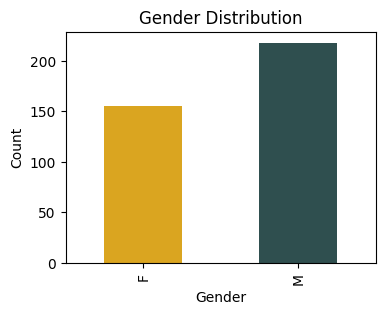

In [5]:
#Create a bar plot for gender distribution
##assign the gender values to gender_counts
gender_counts = df_patient_info['Gender'].value_counts()

## Sort the categories by their index
gender_counts = gender_counts.sort_index()

# Create a bar plot
gender_counts.plot(kind="bar", figsize=(4,3), color=['goldenrod','darkslategrey'])

# Customize the plot 
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the plot
plt.show()

There are less females than males in the clinical dataset. In this case, there are 152 samples for females and 218 samples for males. While there is a class imbalance, it's not extremely skewed. Therefore I will not apply imbalancing technique to handle the data.

##### Age ** when you decide to use age as feature remove the outliers!!!

3


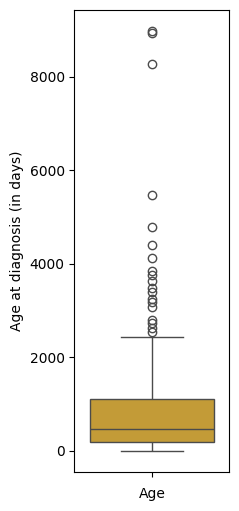

In [6]:
# check how many outliers  above 15 years old
print((df_patient_info['Age'] > 5475).sum()) #5475days=365*15

#Create a boxplot for age distribution
#assign the age values to age_data
age_data = df_patient_info['Age']

## Create a box plot for the 'Age' feature

plt.figure(figsize=(2, 6)) #set the figure size
sns.boxplot(y= age_data, color = 'goldenrod')
# Customize the plot 
plt.ylabel('Age at diagnosis (in days)')
plt.xlabel('Age')
# Show the plot
plt.show()


Here I can see these outliers of age in the data.
I decided to remove them when I use the age as a feature.

* I did some literature research :
* Paper1: https://www.nature.com/articles/nrdp201678 "90% of tumours arise in children who are <10 years".
* Paper2: https://www.degruyter.com/document/doi/10.1515/jpem-2018-0273/html?lang=en : "between 0 and 15.8 years of age at diagnosis"

It is possible that these outliers can be natural outliers. But I decided to drop these outliers since they are only 3 (Age >15years old(5475 days (365*15)))


In [7]:
# check how many outliers  above 15 years old
print((df_patient_info['Age'] > 5475).sum()) #5475days=365*15
print(df_patient_info.shape)

3
(373, 8)


##### Use this code to drop the age outliers when you use it as feature

In [8]:
# # Drop the outliers from Age ((Age >15years old))

# threshold=365*15 #Age 15 in days

# # Create a boolean mask for samples with Age greater than the threshold
# mask = df_patient_info['Age'] > threshold

# # Use the mask condition to create a new DataFrame without outliers
# df_patient_info= df_patient_info[~mask]


# print(df_patient_info.shape)
# df_patient_info


# #plot the Age again

# plt.figure(figsize=(2, 6)) #set the figure size
# sns.boxplot(y= df_patient_info['Age'], color = 'goldenrod')
# # Customize the plot 
# plt.ylabel('Age at diagnosis (in days)')
# plt.xlabel('Age')
# # Show the plot
# plt.show()

##### Clinico genetic subgroups- if I decide to use this feature I will do imbalance samplin approach

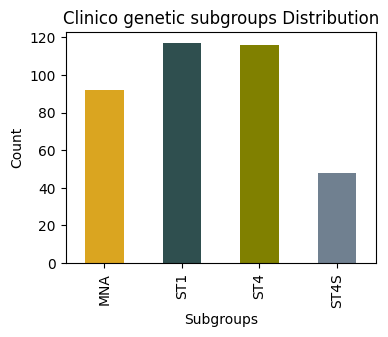

In [9]:
#Create a bar plot for clinico.genetic.subgroup distribution
##assign the gender values to gender_counts
genetic_sub_counts = df_patient_info['clinico.genetic.subgroup'].value_counts()

## Sort the categories by their index
genetic_sub_counts = genetic_sub_counts.sort_index()

# Create a bar plot
genetic_sub_counts.plot(kind="bar", figsize=(4,3), color=['goldenrod','darkslategrey','olive','slategrey'])

# Customize the plot 
plt.title('Clinico genetic subgroups Distribution')
plt.xlabel('Subgroups')
plt.ylabel('Count')

# Show the plot
plt.show()

In [10]:
# Count the unique values in the 'clinico.genetic.subgroup' feature
df_patient_info['clinico.genetic.subgroup'].value_counts()

clinico.genetic.subgroup
ST1     117
ST4     116
MNA      92
ST4S     48
Name: count, dtype: int64

* Here I can see that ST4S has the lowest counts amoung others. Here again we can talk about imbalanced data. MNA and ST4S numbers < ST1 and ST4 numbers.
* Class imbalance can impact the performance of model. If I will use this feature  I might employ imbalanced sample techniques (such as oversampling, undersampling) to address this issue.(Data preprocessing step after split the data).
* Important note: clinico.genetic.subgroup is related to age, INSS Stage and MYCN status.
* I cannot use it as feature for INSS stage
* I can only use it as feature for HighRisk together with Gender only + microarray data
* I can only use it as feature for Progression together with Gender only + microarray data
* I can only use it as feature for DeathfromDisease together with Gender only + microarray data

##### MYCN.status- if I decide to use this feature I will do imbalance samplin approach

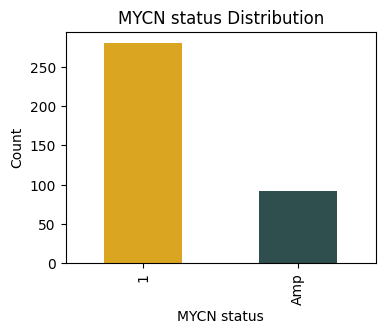

In [11]:
#Create a bar plot for MYCN.status distribution
##assign the gender values to gender_counts
MYCN_status_counts = df_patient_info['MYCN.status'].value_counts()

## Sort the categories by their index
MYCN_status_counts = MYCN_status_counts.sort_index()

# Create a bar plot
MYCN_status_counts.plot(kind="bar", figsize=(4,3), color=['goldenrod','darkslategrey'])

# Customize the plot 
plt.title('MYCN status Distribution')
plt.xlabel('MYCN status')
plt.ylabel('Count')

# Show the plot
plt.show()

In [12]:
# Count the unique values in the 'clinico.genetic.subgroup' feature
df_patient_info['MYCN.status'].value_counts()

MYCN.status
1      281
Amp     92
Name: count, dtype: int64

* Here again we have imbalance feature. 1 (no Amp) > Amp. 
* Class imbalance can impact the performance of model. If I will use this feature  I might employ imbalanced sample techniques (such as oversampling, undersampling) to address this issue.(Data preprocessing step after split the data).


* Category names are not informative. I will change them 1: NoAmp and Amp:Amp **

#### Visualisation of clinical endpoints

##### INSS.Stages- when I set the datasets for the predicting the INSS.Stages I will remove the Stage2,Stage2a and Stage2b

In [13]:
#Change the category names of "MYCN.status"

# Define the mapping of values to replace
mapping = {"1": "NoAmp", "Amp": "Amp"}

# Replace values in the 'MYCN.status' column using the mapping
df_patient_info['MYCN.status'] = df_patient_info['MYCN.status'].replace(mapping)

#check the data
print(df_patient_info['MYCN.status'].value_counts())



MYCN.status
NoAmp    281
Amp       92
Name: count, dtype: int64


#### Understand the INSS 7 stages before move on
* In the internet, there is a clear indication of 6 stages (1, 2 (2a, 2b),3, 4, 4S). But here we have 7 stages. I want to understand what are those.
* I also checked the research paper and they only have stage2 but not 2a and 2b.

![Local Image](INSS_Stage.png)

*I therefore decide to remove from when I set the train and test data for INSS because: 
I will therefore remove Stage 2a and 2b but when I split the data, Stage 2 (which has single value) there is a possibility that it will end up either train or test data. If it is in the train data, one sample will not be very informative and which will cause high imbalance data. If it will be in test, because model is not trained with this stage, it cannot make a decision. Therefore I decided to remove all of them.

##### INSS.Stage- Imbalance data, when I set the train-test for it I have to do oversampling for some samples, and remove stage2,2a and 2b

In [14]:
#check the distribution of categories within the output
print(df_patient_info['INSS.Stage'].value_counts())

INSS.Stage
4     181
1     120
4S     52
3      15
2a      3
2b      1
2       1
Name: count, dtype: int64


##### HighRisk- subcategories are balanced.

In [15]:
#check the distribution of categories within the output
print(df_patient_info['HighRisk'].value_counts())

HighRisk
LR    198
HR    175
Name: count, dtype: int64


##### Progression- subcategories slightly imbalanced

In [16]:
#check the distribution of categories within the output
print(df_patient_info['Progression'].value_counts())

Progression
0    226
1    147
Name: count, dtype: int64


#### DeathFromDisease-subcategories are imbalanced.

In [17]:
#check the distribution of categories within the output
print(df_patient_info['DeathFromDisease'].value_counts())

DeathFromDisease
0    277
1     96
Name: count, dtype: int64


#### Examine the clinical data with cross tabulation (Feature bias)
Crosstab (contingency table analysis) is a useful analysis tool commonly used to compare the results for one or more variables with the results of another variable. My purpose is to understand how clinical features have a relationship between our predictive indicators (clinical endpoints).
 

* Clinical features: Gender, Age, clinico.genetic.subgroup, MYCN.status
* Clinical endpoints: INSS.Stage, HighRisk, Progression, DeathFromDisease

In [18]:
#Function for cross_comparison for categorical variables
def cross_comparison(factor1 = None, factor2 = None ):
    factor1_vs_factor2 = pd.DataFrame(pd.crosstab( df_patient_info[factor1], df_patient_info[factor2] ))
    print(factor1_vs_factor2)
    factor1_vs_factor2.index = sorted(df_patient_info[factor1].unique())
    ax = factor1_vs_factor2.plot.bar()
    ax.set_title (f'{factor1} vs {factor2}')
    ax.set_xlabel(factor1)
    ax.set

#### Gender

INSS.Stage   1  2  2a  2b  3    4  4S
Gender                               
F           57  0   2   1  6   70  19
M           63  1   1   0  9  111  33


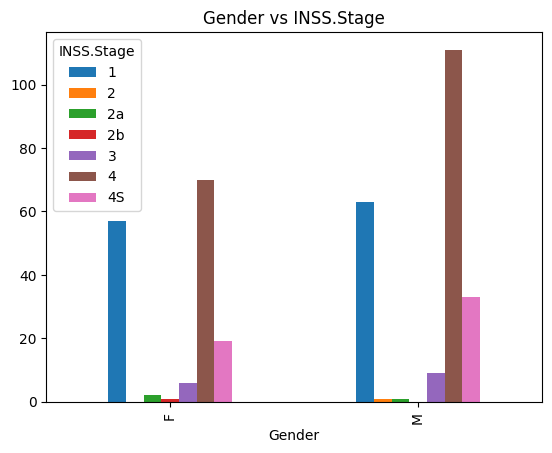

In [19]:
### Gender vs INSS Stage
cross_comparison(factor1 = "Gender", factor2 = "INSS.Stage" )

It seems like 2b is only observed in Females and 2 is only observed in males. There are more males in Stage 4 and Stage 4S than females. Stage2 in general has a less representation for gender.


HighRisk   HR   LR
Gender            
F          64   91
M         111  107


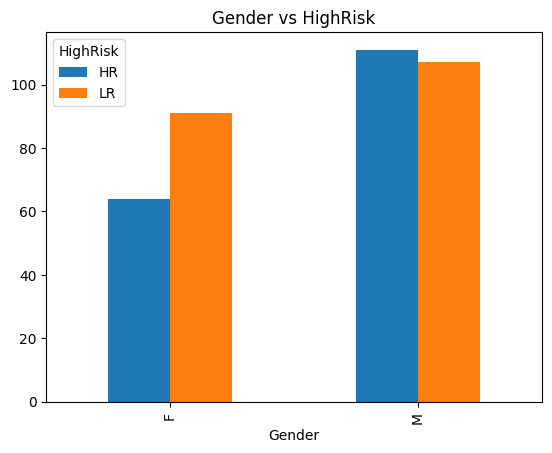

In [20]:
### Gender vs HighRisk
cross_comparison(factor1 = "Gender", factor2 = "HighRisk" )

Here we can see that there are more male samples with HR. Gender feature can provide a slight bias to model learning.

Progression    0   1
Gender              
F             94  61
M            132  86


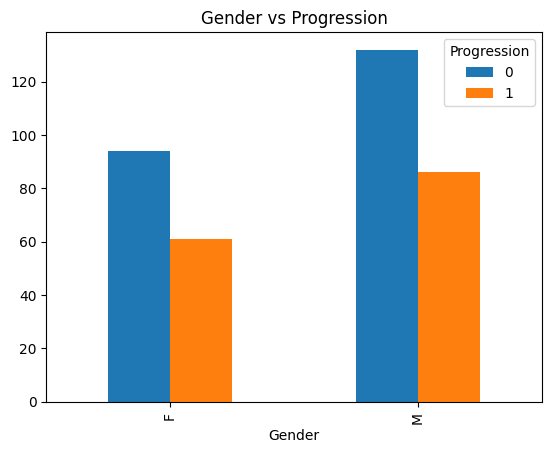

In [21]:
### Gender vs Progression
cross_comparison(factor1 = "Gender", factor2 = "Progression" )

Progression is represented among genders is quite okey compared to reduced female samples. If I use stratified cross-validation it should be fine.

DeathFromDisease    0   1
Gender                   
F                 112  43
M                 165  53


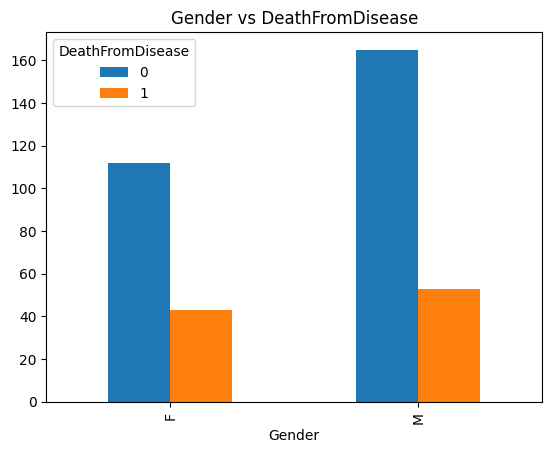

In [22]:
### Gender vs DeathFromDisease
cross_comparison(factor1 = "Gender", factor2 = "DeathFromDisease" )

DeathFromDisease is represented among genders is quite okey compared to reduced female samples. If I use stratified cross-validation it should be fine.

##### Overall "Gender" can be used to predict Progression, DeathFromDisease but can be a bias feature for HighRisk and INSS

In [23]:
#Function for boxplot of continuous and categorical variables (order is important)
def cross_comparison_boxplot(factor1=None, factor2=None):
    # Check if factor1 is numeric
    if not pd.api.types.is_numeric_dtype(df_patient_info[factor1]):
        print(f"{factor1} is not a numeric variable. Box plots require a numeric variable for the y-axis.")
        return
    
    # Sort the order of categories for factor2
    factor2_order = sorted(df_patient_info[factor2].unique())

    # Create a box plot to compare the continuous variable (factor1) across categories of the categorical variable (factor2)
    plt.figure(figsize=(6, 6)) 
    sns.boxplot(x=factor2, y=factor1, data=df_patient_info, palette='pastel',hue=factor2, order= factor2_order)
    
    plt.title(f'{factor1} vs {factor2}')
    plt.xlabel(factor2)
    plt.ylabel(factor1)  # Adjust the y-label as needed
    
    plt.show()


##### Age

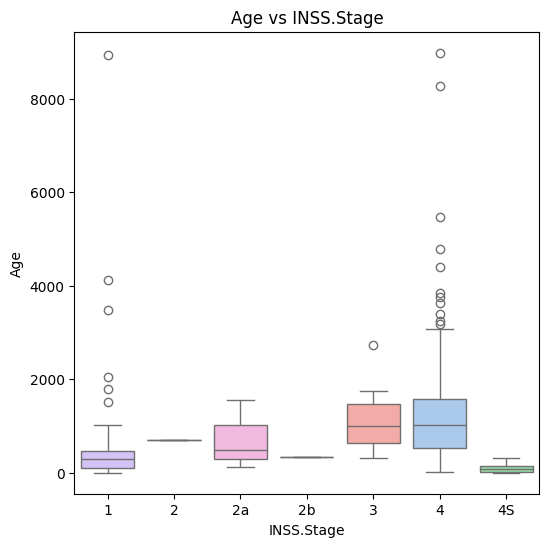

In [24]:
### Age vs INSS.Stage
cross_comparison_boxplot(factor1 = "Age", factor2 = "INSS.Stage" )


Age values is vary among INSS.Stages (mostly between 0 days at diagnosis and 2000).Only in stage 3 and stage4 is relatively similar. This relationship between age and INSS stage can potentially introduce bias when using age as a feature in predictive modeling or statistical analysis. If there's a strong correlation between age and INSS stage, using age as a predictor might lead the model to make predictions based on age rather than the true underlying factors that influence INSS stage. 

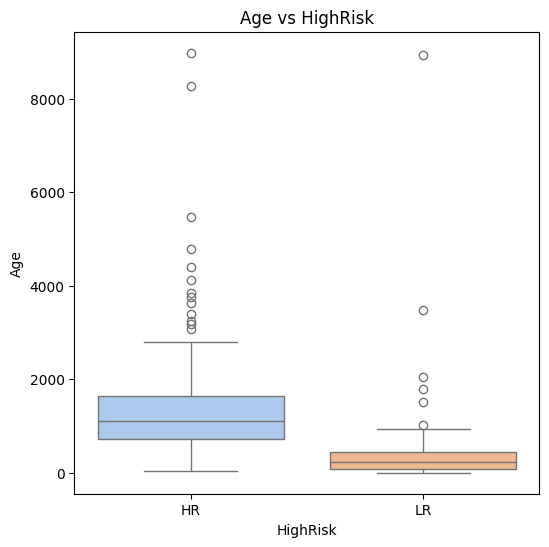

In [25]:
### Age vs HighRisk
cross_comparison_boxplot(factor1 = "Age", factor2 = "HighRisk" )

Age is also bias in HighRisk

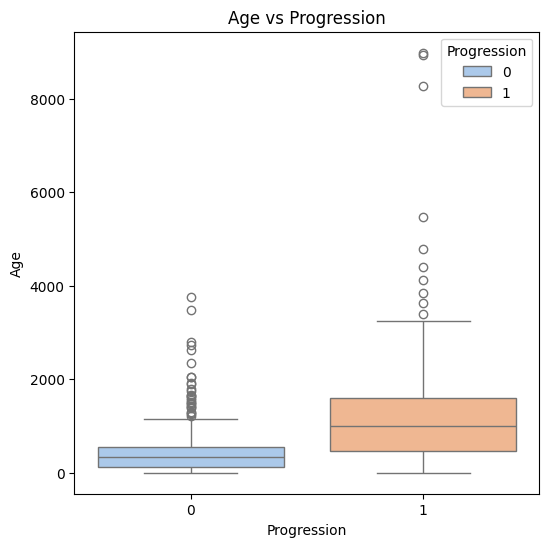

In [26]:
### Age vs Progression
cross_comparison_boxplot(factor1 = "Age", factor2 = "Progression" )

Age is also bias in Progression

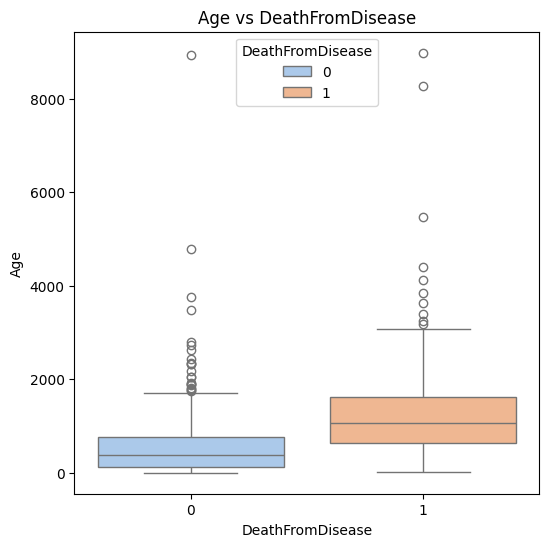

In [27]:
### Age vs DeathFromDisease
cross_comparison_boxplot(factor1 = "Age", factor2 = "DeathFromDisease" )

Age is also bias in DeathFrom Disease.

##### Overall Age seems like a bias feature for all clinical endpoints.

#### clinico.genetic.subgroup

INSS.Stage                  1  2  2a  2b   3    4  4S
clinico.genetic.subgroup                             
MNA                         3  1   3   1  15   65   4
ST1                       117  0   0   0   0    0   0
ST4                         0  0   0   0   0  116   0
ST4S                        0  0   0   0   0    0  48


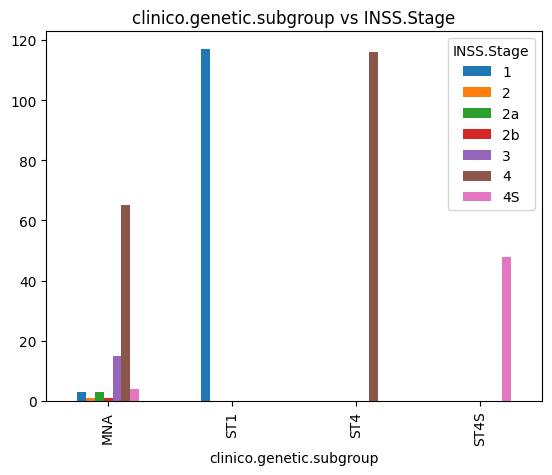

In [28]:
### clinico.genetic.subgroup vs INSS.Stage
cross_comparison(factor1 = "clinico.genetic.subgroup", factor2 = "INSS.Stage" )

clinico.genetic.subgroup is a significantly bias feature INSS.Stage. It is anyway associated with INSS.Stage

HighRisk                  HR   LR
clinico.genetic.subgroup         
MNA                       92    0
ST1                        0  117
ST4                       83   33
ST4S                       0   48


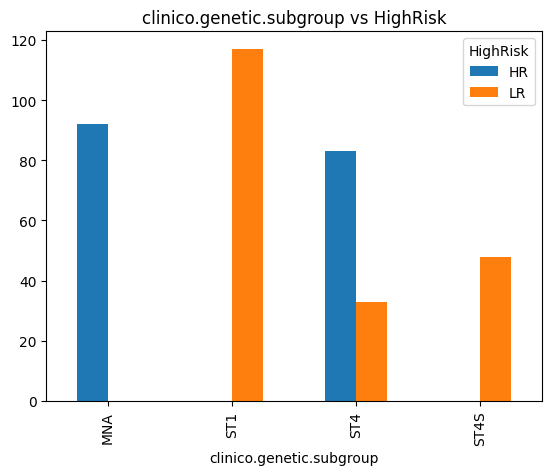

In [29]:
### clinico.genetic.subgroup vs HighRisk
cross_comparison(factor1 = "clinico.genetic.subgroup", factor2 = "HighRisk" )

clinico.genetic.subgroup is also bias feature for HighRisk. For example, HR is only observed in MNA subgroup. And LR is only observed in ST1 and ST4S.

Progression                 0   1
clinico.genetic.subgroup         
MNA                        32  60
ST1                       110   7
ST4                        48  68
ST4S                       36  12


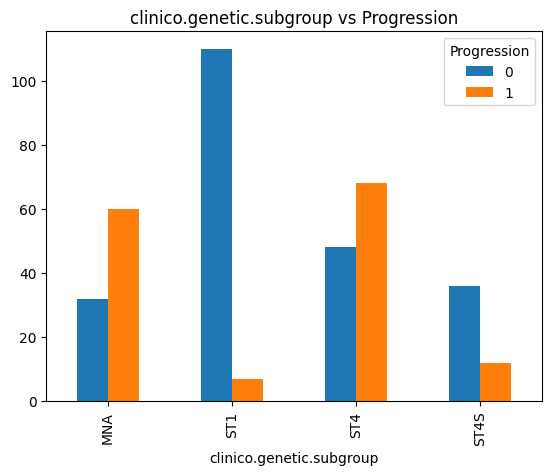

In [30]:
### clinico.genetic.subgroup vs Progression
cross_comparison(factor1 = "clinico.genetic.subgroup", factor2 = "Progression" )

Although for MNA and ST4 subgroups show a similar results, clinico.genetic.subgroup is also bias feature for Progression. 

DeathFromDisease            0   1
clinico.genetic.subgroup         
MNA                        41  51
ST1                       117   0
ST4                        74  42
ST4S                       45   3


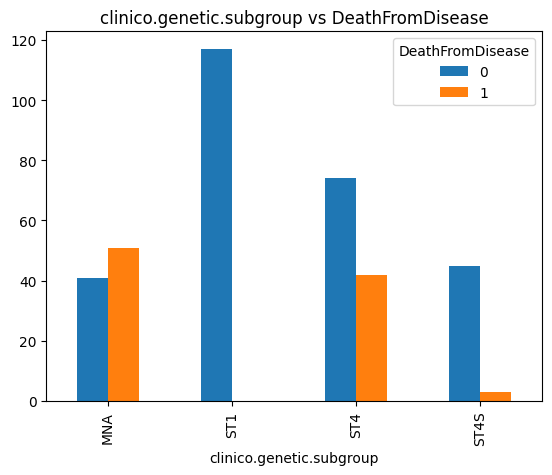

In [31]:
### clinico.genetic.subgroup vs DeathFromDisease
cross_comparison(factor1 = "clinico.genetic.subgroup", factor2 = "DeathFromDisease" )

clinico.genetic.subgroup is also bias feature for DeathFromDisease. 

##### Overall clinico.genetic.subgroup seems like a bias feature for all clinical endpoints.

##### MYCN.status

INSS.Stage     1  2  2a  2b   3    4  4S
MYCN.status                             
Amp            3  1   3   1  15   65   4
NoAmp        117  0   0   0   0  116  48


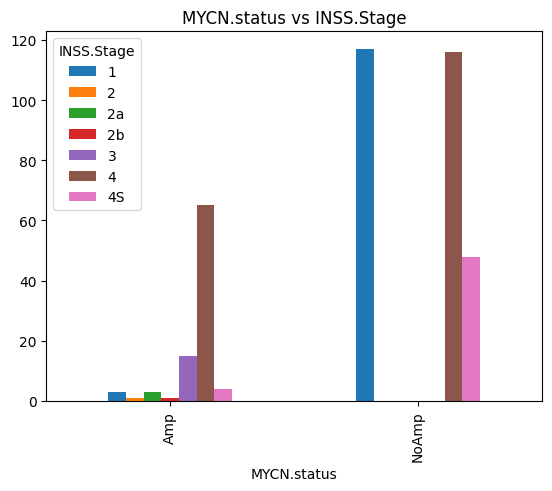

In [32]:
### MYCN.status vs INSS.Stage
cross_comparison(factor1 = "MYCN.status", factor2 = "INSS.Stage" )

MYCN.status is bias feature for INSS.Stage.It is a bit weird because Amp is associted with severity. But it seems like No amplification can be seen both in stage1 and Stage4 whereas Amp seen mostly in Stage4 (severe).

HighRisk     HR   LR
MYCN.status         
Amp          92    0
NoAmp        83  198


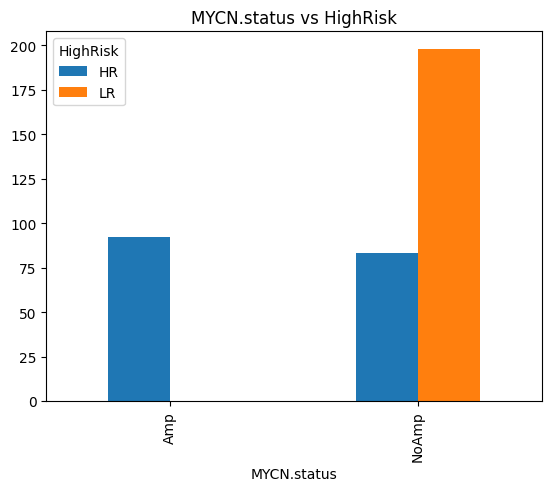

In [33]:
### MYCN.status vs HighRisk
cross_comparison(factor1 = "MYCN.status", factor2 = "HighRisk" )

MYCN.status is bias feature for HighRisk.Amplified MYCN we don't see low risk patients. Amplification seems like correlated with Amplification.

Progression    0   1
MYCN.status         
Amp           32  60
NoAmp        194  87


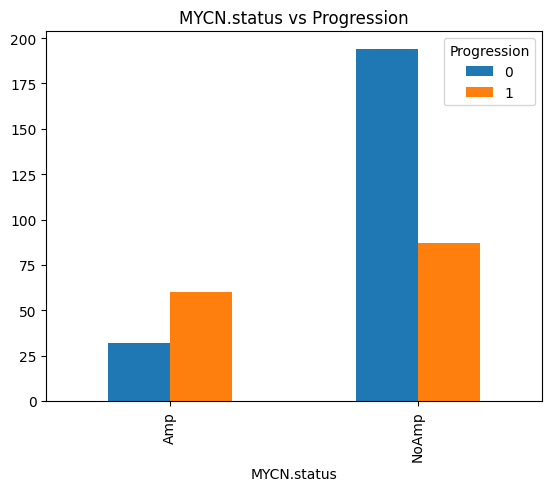

In [34]:
### MYCN.status vs Progression
cross_comparison(factor1 = "MYCN.status", factor2 = "Progression" )

It is also a bias feature. When we have no amplification we have more patients with no progression and versa versa. 

DeathFromDisease    0   1
MYCN.status              
Amp                41  51
NoAmp             236  45


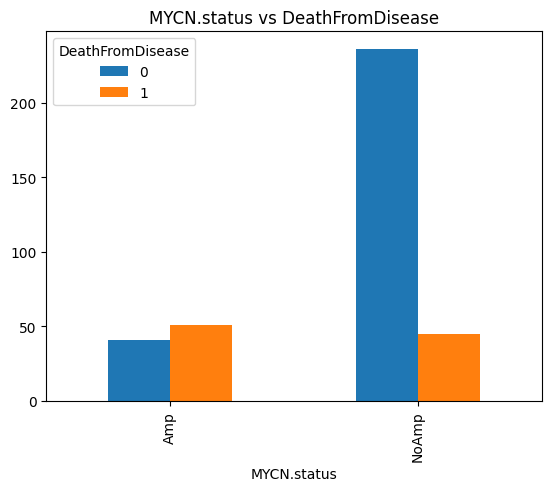

In [35]:
### MYCN.status vs DeathFromDisease
cross_comparison(factor1 = "MYCN.status", factor2 = "DeathFromDisease" )

It is also a bias feature. When we have no amplification we have more patients with no death and when there is a Amp interestingly we have both death and alive patients

#### Final thoughts they are some imbalancing both in clinical features and clinical endpoints. Best to handle them during the preprocessing step, I will assign them for each different X and y and have a look the solutions one by one. Furthermore, I will check the feature importance of clinical features if they are not importance I will maybe not continue with them.

##### Check missing data for clinical data -No missing data for clinical features.

In [36]:
#count NAs in the clinical data
print("Missing values in clinical data:")
print("________________________________")
print(df_patient_info.isna().sum()) 

Missing values in clinical data:
________________________________
Gender                      0
Age                         0
clinico.genetic.subgroup    0
MYCN.status                 0
INSS.Stage                  0
HighRisk                    0
Progression                 0
DeathFromDisease            0
dtype: int64


Likely we don't have missing data that we need to handle in clinical data.

In [5]:
# Load the microarray dataset
df_m_array = pd.read_csv(fn_m_array) #load the dataset 
#print(df_m_array.head(3))

#In the dataset we have these columns: Reporter.Identifier, GeneSymbols and the probes. It seems like 
# Reporter.Identifier doesn't necessary for us and we can drop it. And we can assign the GeneSymbols as index

# Drop the "Reporter.Identifier" column
df_m_array = df_m_array.drop(['Reporter.Identifier'],axis=1)

# Set the "GeneSymbols" column as the index
df_m_array = df_m_array.set_index('GeneSymbols')

df_m_array

,ICGC_001_TCGA,ICGC_002_TCGA,ICGC_003_TCGA,ICGC_004,ICGC_005,ICGC_006,ICGC_007,ICGC_008,ICGC_009_TCGA,ICGC_010,...,ICGC_489,ICGC_490,ICGC_491_TCGA,ICGC_492,ICGC_493,ICGC_494_TCGA,ICGC_495,ICGC_496_TCGA,ICGC_497,ICGC_498
GeneSymbols,,,,,,,,,,,,,,,,,,,,,
NaN,14.99,14.94,12.48,14.63,11.89,15.09,13.07,12.00,NaN,12.27,...,13.62,13.03,14.98,13.36,13.90,13.00,13.79,14.70,14.03,12.31
NaN,9.20,10.41,9.27,8.83,NaN,10.33,9.62,8.72,9.36,8.41,...,6.26,5.93,6.97,5.99,7.62,7.76,8.56,7.74,7.57,NaN
NaN,5.06,5.26,6.45,2.89,2.00,4.80,3.05,6.39,6.43,NaN,...,0.93,0.58,1.26,1.38,3.49,2.07,2.26,2.29,NaN,2.54
NaN,7.45,8.68,6.30,7.30,6.26,7.50,7.43,6.98,8.02,7.31,...,5.35,5.57,5.51,6.30,6.60,6.38,7.49,6.77,8.13,NaN
NaN,6.74,6.63,6.75,6.20,6.57,6.01,6.78,4.80,5.15,4.42,...,4.58,4.61,3.54,4.55,4.20,7.16,7.07,5.07,6.28,6.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,10.35,10.33,9.81,10.36,9.65,10.46,9.17,10.23,10.16,NaN,...,8.60,7.37,8.22,8.44,10.17,NaN,10.09,9.68,9.98,9.40
NaN,17.05,16.62,17.45,16.72,16.93,17.69,16.85,18.07,16.98,17.41,...,17.14,16.79,NaN,16.71,16.46,16.83,17.16,17.24,17.11,NaN
NaN,5.30,6.84,5.29,5.33,4.81,6.62,6.52,5.37,5.65,5.94,...,4.07,3.05,2.77,4.14,3.94,4.19,6.85,4.99,4.51,3.34


#### Descriptive analysis for microarray data

In [40]:
#transpose the microarray
df_m_array_transpose = pd.DataFrame(df_m_array.transpose())
#assign the index name as ID
df_m_array_transpose = df_m_array_transpose.rename_axis("ID")

In [7]:
df_m_array_transpose

GeneSymbols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STK24,NaN,NaN,...,NaN,NaN,PDE3B,NaN,LINC01588,NaN,NaN,NaN,NaN,NaN
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_001_TCGA,14.99,9.20,5.06,7.45,6.74,NaN,17.27,12.14,3.04,7.85,...,7.33,9.11,13.37,6.02,7.89,10.35,17.05,5.30,13.91,14.54
ICGC_002_TCGA,14.94,10.41,5.26,8.68,6.63,4.05,NaN,12.36,4.10,7.58,...,7.94,9.95,NaN,8.32,NaN,10.33,16.62,6.84,13.57,NaN
ICGC_003_TCGA,12.48,9.27,6.45,6.30,6.75,4.91,17.79,11.72,4.27,7.82,...,8.40,7.51,10.85,6.67,7.84,9.81,17.45,5.29,NaN,14.33
ICGC_004,14.63,8.83,2.89,7.30,6.20,3.00,17.45,11.31,4.12,7.01,...,NaN,8.54,10.04,7.28,8.20,10.36,16.72,5.33,13.84,14.76
ICGC_005,11.89,NaN,2.00,6.26,6.57,NaN,17.38,10.90,3.10,6.50,...,6.65,8.34,11.10,7.21,7.41,9.65,16.93,4.81,13.22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_494_TCGA,13.00,7.76,2.07,6.38,7.16,2.20,17.18,11.45,3.45,6.77,...,9.04,9.09,12.00,6.13,7.29,NaN,16.83,4.19,13.50,13.82
ICGC_495,13.79,8.56,2.26,7.49,7.07,2.41,17.50,12.18,2.29,NaN,...,8.79,9.57,12.67,7.41,8.20,10.09,17.16,6.85,NaN,14.82
ICGC_496_TCGA,14.70,7.74,2.29,6.77,5.07,2.38,17.51,11.94,NaN,6.42,...,7.23,9.17,11.65,7.19,9.19,9.68,17.24,4.99,13.99,14.17


##### Descriptive analysis for microarray data

In [40]:
df_m_array_transpose.describe()

GeneSymbols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STK24,NaN,NaN,...,NaN,NaN,PDE3B,NaN,LINC01588,NaN,NaN,NaN,NaN,NaN
count,441.000000,455.000000,450.00000,453.000000,452.000000,438.000000,447.000000,470.000000,443.000000,430.000000,...,444.000000,452.000000,444.000000,454.000000,460.000000,448.000000,442.000000,439.000000,440.000000,446.000000
mean,13.595782,8.165275,2.70460,6.890287,5.613385,2.592740,17.354541,11.753915,2.714312,6.654953,...,8.068086,9.004049,11.659302,7.020022,7.787630,9.479085,16.818484,4.593918,13.682159,14.195516
std,1.122512,1.205569,1.33888,1.013816,1.378360,1.076579,0.540344,0.613476,1.232665,1.004114,...,1.170913,0.934065,1.275872,0.952267,1.148513,0.925392,0.512296,1.462073,0.511352,0.629266
min,9.920000,3.680000,0.49000,2.660000,0.770000,0.490000,14.830000,9.560000,0.000000,1.720000,...,4.690000,4.750000,7.640000,3.630000,3.460000,5.990000,13.960000,0.140000,11.890000,11.950000
25%,12.950000,7.440000,1.72000,6.320000,4.750000,1.780000,17.005000,11.350000,1.850000,6.220000,...,7.230000,8.480000,10.885000,6.482500,7.060000,8.980000,16.480000,3.640000,13.367500,13.830000
50%,13.700000,8.190000,2.49000,6.970000,5.735000,2.510000,17.380000,11.815000,2.680000,6.810000,...,8.065000,9.080000,11.740000,7.025000,7.835000,9.610000,16.855000,4.610000,13.750000,14.240000
75%,14.390000,9.060000,3.23000,7.540000,6.610000,3.185000,17.720000,12.217500,3.505000,7.285000,...,8.790000,9.680000,12.617500,7.627500,8.532500,10.120000,17.160000,5.805000,14.030000,14.600000
max,16.470000,10.590000,6.94000,10.270000,8.780000,8.590000,18.920000,13.200000,7.630000,8.570000,...,12.200000,11.480000,14.990000,10.060000,12.520000,11.370000,18.070000,7.900000,14.750000,15.760000


##### In the clinical data we have 373 samples and in microarray data we have 498 samples. We can check the overlapping samples with Venn diagram

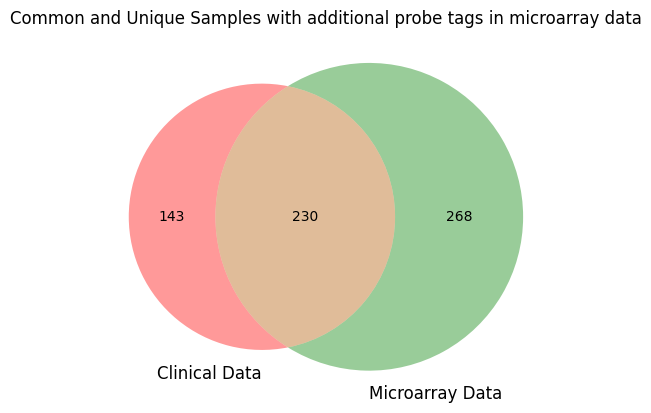

In [41]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

clinical_ids = set(df_patient_info.index)  # Get the index of clinical data in a new variable
sample_ids = set(df_m_array_transpose.index)  # Get the index of microarray data in a new variable

missing_samples = clinical_ids.intersection(sample_ids)

# Create the Venn diagram and set labels for A and B
venn2([set(clinical_ids), set(sample_ids)], set_labels=('Clinical Data', 'Microarray Data'))
# Add labels for sets A and B
plt.gca().set_title("Common and Unique Samples with additional probe tags in microarray data")

plt.show()

#### 2. Data preprocessing

1. Clean the probe tags from microarray and data merge the data.
2. Data splitting (Train-Test)
3. Data imputation
4. Visualisation of microarray data (melting+box plot) to check the variability
5. Outlier removal
6. Normalisation
7. Filtrating the features have little/no variance
8. Unsupervised learning (to check if the data can split (Dimensionality reduction+clustering))




NOTE for outlier handling for gene expression data!!!: One small trick is that we use z score normalisation to normalise the data and then anything beyond two or three z-score we can consistantly eliminate them.
On the other hand, the samples that have consistent zero values across all the samples, we shoul also eliminate them because they are non informative and they are not really saying anything new.

The microarray dataset shows that 498 samples (probes) and 44708 genes in the dataset. But the probe numbers are not matching with clinical data probe numbers (373). I must look this problem more closely in data preprocessing step.

##### In the clinical data we have 373 samples and in microarray data we have 498 samples. We can check the overlapping samples with Venn diagram

Microarray data has 498 samples and clinical data has 373 samples.And from them it seems only 230 samples are overlapping. Why is this the case? To solve this mystery,I need to check the data sets again.

In [42]:
#Subtract the data which is only found in clinical data (143 samples)
only_in_clinical = list(set(df_patient_info.index.to_list()) - set(df_m_array_transpose.index.to_list()))
print(only_in_clinical)
#check the sample sizes if it fits to Venn diagram
print(len(only_in_clinical))


['ICGC_487', 'ICGC_086', 'ICGC_277', 'ICGC_428', 'ICGC_197', 'ICGC_009', 'ICGC_254', 'ICGC_413', 'ICGC_351', 'ICGC_284', 'ICGC_155', 'ICGC_391', 'ICGC_462', 'ICGC_344', 'ICGC_348', 'ICGC_482', 'ICGC_300', 'ICGC_483', 'ICGC_415', 'ICGC_433', 'ICGC_238', 'ICGC_030', 'ICGC_439', 'ICGC_371', 'ICGC_096', 'ICGC_470', 'ICGC_366', 'ICGC_373', 'ICGC_092', 'ICGC_236', 'ICGC_392', 'ICGC_160', 'ICGC_107', 'ICGC_306', 'ICGC_108', 'ICGC_168', 'ICGC_374', 'ICGC_161', 'ICGC_399', 'ICGC_496', 'ICGC_106', 'ICGC_414', 'ICGC_321', 'ICGC_055', 'ICGC_386', 'ICGC_158', 'ICGC_445', 'ICGC_385', 'ICGC_301', 'ICGC_409', 'ICGC_379', 'ICGC_389', 'ICGC_249', 'ICGC_250', 'ICGC_164', 'ICGC_440', 'ICGC_169', 'ICGC_037', 'ICGC_246', 'ICGC_367', 'ICGC_280', 'ICGC_269', 'ICGC_355', 'ICGC_296', 'ICGC_404', 'ICGC_398', 'ICGC_026', 'ICGC_325', 'ICGC_195', 'ICGC_324', 'ICGC_025', 'ICGC_060', 'ICGC_376', 'ICGC_326', 'ICGC_242', 'ICGC_214', 'ICGC_015', 'ICGC_316', 'ICGC_283', 'ICGC_412', 'ICGC_343', 'ICGC_260', 'ICGC_278', 'IC

In [43]:
#Subtract the data which is only found in microarray data (268 samples)
only_in_m_array = list( set(df_m_array_transpose.index.to_list()) - set(df_patient_info.index.to_list())) #special to microarray
print(only_in_m_array)
#check the sample sizes if it fits to Venn diagram
print(len(only_in_m_array))

['ICGC_260_TCGA', 'ICGC_244_TCGA', 'ICGC_061_TCGA', 'ICGC_072', 'ICGC_361', 'ICGC_311_TCGA', 'ICGC_214_TCGA', 'ICGC_037_TCGA', 'ICGC_041', 'ICGC_135', 'ICGC_413_TCGA', 'ICGC_351_TCGA', 'ICGC_219', 'ICGC_065_TCGA', 'ICGC_143_TCGA', 'ICGC_146_TCGA', 'ICGC_171', 'ICGC_151_TCGA', 'ICGC_176', 'ICGC_124_TCGA', 'ICGC_279_TCGA', 'ICGC_310_TCGA', 'ICGC_028_TCGA', 'ICGC_439_TCGA', 'ICGC_477_TCGA', 'ICGC_228', 'ICGC_487_TCGA', 'ICGC_001_TCGA', 'ICGC_450', 'ICGC_312', 'ICGC_380_TCGA', 'ICGC_196_TCGA', 'ICGC_134', 'ICGC_480_TCGA', 'ICGC_229_TCGA', 'ICGC_168_TCGA', 'ICGC_025_TCGA', 'ICGC_136_TCGA', 'ICGC_223', 'ICGC_232_TCGA', 'ICGC_085_TCGA', 'ICGC_192', 'ICGC_030_TCGA', 'ICGC_150', 'ICGC_415_TCGA', 'ICGC_088_TCGA', 'ICGC_092_TCGA', 'ICGC_081_TCGA', 'ICGC_190_TCGA', 'ICGC_433_TCGA', 'ICGC_425_TCGA', 'ICGC_231_TCGA', 'ICGC_188_TCGA', 'ICGC_217', 'ICGC_233_TCGA', 'ICGC_316_TCGA', 'ICGC_382', 'ICGC_344_TCGA', 'ICGC_076', 'ICGC_147_TCGA', 'ICGC_107_TCGA', 'ICGC_193', 'ICGC_009_TCGA', 'ICGC_047_TCGA', '

It seems like some of the microarray data has some tags after the probe ids.I need to delete them to match with the rest.

In [44]:
## Function to split a string based on separator and return the first value

#subset the ids from df_m_array
m_array_sample_names = df_m_array_transpose.index.to_list()
def correct_sample_names(sample_name=None, separator = "_"): #we pass the sample name as string and separator as "_"
    parts = sample_name.split(separator) # Split the string using the separator
    if len(parts) >= 2:  # Ensure at least two parts exist
        return separator.join(parts[:2])
    else:
        return sample_name
 
print("Before Update")
print(m_array_sample_names)

#for every single element of the m_array_sample_names apply this function ("correct_sample_names") and assign the result in  a new list
m_array_sample_names_updated = [correct_sample_names(sub) for sub in m_array_sample_names] #we call the function for this "sub" element (which is actually element of the m_array_sample_names list) in m_array_sample_names

print("After Update")
print(m_array_sample_names_updated)

Before Update
['ICGC_001_TCGA', 'ICGC_002_TCGA', 'ICGC_003_TCGA', 'ICGC_004', 'ICGC_005', 'ICGC_006', 'ICGC_007', 'ICGC_008', 'ICGC_009_TCGA', 'ICGC_010', 'ICGC_011', 'ICGC_012', 'ICGC_013', 'ICGC_014_TCGA', 'ICGC_015_TCGA', 'ICGC_016', 'ICGC_017_TCGA', 'ICGC_018_TCGA', 'ICGC_019', 'ICGC_020', 'ICGC_021', 'ICGC_022', 'ICGC_023', 'ICGC_024_TCGA', 'ICGC_025_TCGA', 'ICGC_026_TCGA', 'ICGC_027_TCGA', 'ICGC_028_TCGA', 'ICGC_029', 'ICGC_030_TCGA', 'ICGC_031', 'ICGC_032', 'ICGC_033_TCGA', 'ICGC_034', 'ICGC_035_TCGA', 'ICGC_036', 'ICGC_037_TCGA', 'ICGC_038', 'ICGC_039_TCGA', 'ICGC_040', 'ICGC_041', 'ICGC_042', 'ICGC_043_TCGA', 'ICGC_044_TCGA', 'ICGC_045', 'ICGC_046_TCGA', 'ICGC_047_TCGA', 'ICGC_048', 'ICGC_049_TCGA', 'ICGC_050', 'ICGC_051', 'ICGC_052', 'ICGC_053', 'ICGC_054', 'ICGC_055_TCGA', 'ICGC_056', 'ICGC_057', 'ICGC_058', 'ICGC_059', 'ICGC_060_TCGA', 'ICGC_061_TCGA', 'ICGC_062_TCGA', 'ICGC_063_TCGA', 'ICGC_064', 'ICGC_065_TCGA', 'ICGC_066', 'ICGC_067_TCGA', 'ICGC_068', 'ICGC_069', 'ICGC_0

It worked. Now I can update the column names in the microarray data:

In [45]:
#Assign the updated samples names back to the microarray Data
df_m_array_transpose.index = m_array_sample_names_updated

#assign the index name as ID
df_m_array_transpose = df_m_array_transpose.rename_axis("ID")

#check the shape
print(df_m_array_transpose.shape)

#check the data frame
df_m_array_transpose



(498, 44708)


GeneSymbols,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STK24,NaN,NaN,...,NaN,NaN,PDE3B,NaN,LINC01588,NaN,NaN,NaN,NaN,NaN
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_001,14.99,9.20,5.06,7.45,6.74,NaN,17.27,12.14,3.04,7.85,...,7.33,9.11,13.37,6.02,7.89,10.35,17.05,5.30,13.91,14.54
ICGC_002,14.94,10.41,5.26,8.68,6.63,4.05,NaN,12.36,4.10,7.58,...,7.94,9.95,NaN,8.32,NaN,10.33,16.62,6.84,13.57,NaN
ICGC_003,12.48,9.27,6.45,6.30,6.75,4.91,17.79,11.72,4.27,7.82,...,8.40,7.51,10.85,6.67,7.84,9.81,17.45,5.29,NaN,14.33
ICGC_004,14.63,8.83,2.89,7.30,6.20,3.00,17.45,11.31,4.12,7.01,...,NaN,8.54,10.04,7.28,8.20,10.36,16.72,5.33,13.84,14.76
ICGC_005,11.89,NaN,2.00,6.26,6.57,NaN,17.38,10.90,3.10,6.50,...,6.65,8.34,11.10,7.21,7.41,9.65,16.93,4.81,13.22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_494,13.00,7.76,2.07,6.38,7.16,2.20,17.18,11.45,3.45,6.77,...,9.04,9.09,12.00,6.13,7.29,NaN,16.83,4.19,13.50,13.82
ICGC_495,13.79,8.56,2.26,7.49,7.07,2.41,17.50,12.18,2.29,NaN,...,8.79,9.57,12.67,7.41,8.20,10.09,17.16,6.85,NaN,14.82
ICGC_496,14.70,7.74,2.29,6.77,5.07,2.38,17.51,11.94,NaN,6.42,...,7.23,9.17,11.65,7.19,9.19,9.68,17.24,4.99,13.99,14.17


Everthing looks need. Now we can check one more time the venn diagram if we manage to overlap more features:

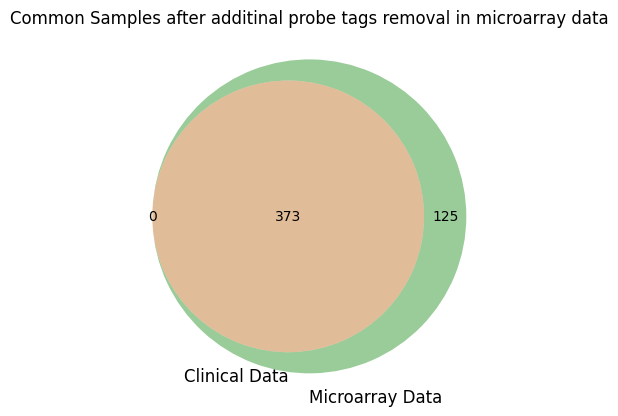

In [46]:
clinical_ids = set(df_patient_info.index)  # Get the index of clinical data in a new variable
sample_ids = set(df_m_array_transpose.index)  # Get the index of microarray data in a new variable

missing_samples = clinical_ids.intersection(sample_ids)

# Create the Venn diagram and set labels for A and B
venn2([set(clinical_ids), set(sample_ids)], set_labels=('Clinical Data', 'Microarray Data'))
# Add labels for sets A and B
plt.gca().set_title("Common Samples after additinal probe tags removal in microarray data")

plt.show()


Perfect, we could overlay all the 373 samples.Now it is time to subset the common samples from datasets such that we can use only these common samples since we also want to merge the datasets to continue on data preprocessing.

In [47]:
## Now Subset the common samples in a list
common_samples = list(clinical_ids.intersection( set(df_m_array_transpose.index) ) )
#check the length of the list if it is 373
print(f'The number of common samples is {len(common_samples)}')

## Subset common clinical samples 
###First assign the df_patient_info to df_patient_info.index. Because ID column as index column have the all probe names
df_patient_info["ID"] = df_patient_info.index

###then we subset the data matches with df_patient_info["ID"] from common samples
df_common_patient_info = df_patient_info[ df_patient_info["ID"].isin(common_samples) ] #.isin() method from pandas Series. The .isin() method checks whether each value in the Series is present in the common_samples list.

#check the new df_common_patients_info dataset
print('____________________________________________')
print(f'Shape of the new clinical data is {df_common_patient_info.shape}')
print('____________________________________________')
print('Here is the the three row from the clinical data:')
print(df_common_patient_info.head(3))

#save the new clinical data as csv
df_common_patient_info.to_csv("df_common_patient_info.csv", sep = ",")


## Subset common microarray samples 
df_common_m_array = df_m_array_transpose.loc[common_samples]

#check the new df_common_m_array dataset
print('____________________________________________')
print(f'Shape of the new microarray data is {df_common_m_array.shape}')
print('____________________________________________')
print('Here is the the three row from the microarray data:')
print(df_common_patient_info.head(3))

#save the new microarray  as csv
df_common_m_array.to_csv("df_common_m_array.csv", sep = ",")


The number of common samples is 373
____________________________________________
Shape of the new clinical data is (373, 9)
____________________________________________
Here is the the three row from the clinical data:
         Gender     Age clinico.genetic.subgroup MYCN.status INSS.Stage  \
ID                                                                        
ICGC_001      M   987.0                      ST4           1          4   
ICGC_002      M  1808.0                      ST4           1          4   
ICGC_003      F   625.0                      MNA         Amp          4   

         HighRisk  Progression  DeathFromDisease        ID  
ID                                                          
ICGC_001       HR            1                 1  ICGC_001  
ICGC_002       HR            1                 1  ICGC_002  
ICGC_003       HR            1                 1  ICGC_003  
____________________________________________
Shape of the new microarray data is (373, 44708)
______

##### One-hot encoding clinical features 

In [48]:
#df_common_patient_info = df_common_patient_info.drop("ID", axis=1)
df_common_patient_info

,Gender,Age,clinico.genetic.subgroup,MYCN.status,INSS.Stage,HighRisk,Progression,DeathFromDisease,ID
ID,,,,,,,,,
ICGC_001,M,987.0,ST4,1,4,HR,1,1,ICGC_001
ICGC_002,M,1808.0,ST4,1,4,HR,1,1,ICGC_002
ICGC_003,F,625.0,MNA,Amp,4,HR,1,1,ICGC_003
ICGC_004,F,335.0,MNA,Amp,2b,HR,0,0,ICGC_004
ICGC_005,F,536.0,MNA,Amp,4,HR,1,1,ICGC_005
...,...,...,...,...,...,...,...,...,...
ICGC_494,M,56.0,ST1,1,1,LR,0,0,ICGC_494
ICGC_495,M,163.0,ST1,1,1,LR,0,0,ICGC_495
ICGC_496,M,132.0,ST1,1,1,LR,1,0,ICGC_496


In [49]:
#For "Gender"
#import the library
from sklearn.preprocessing import  OneHotEncoder


one_hot_encoder = OneHotEncoder(sparse=False)
gender_encoded = one_hot_encoder.fit_transform(df_common_patient_info['Gender'].values.reshape(-1, 1))

# Create a DataFrame from the one-hot encoded array
gender_encoded_df = pd.DataFrame(gender_encoded, columns=one_hot_encoder.get_feature_names_out(['Gender']))
gender_encoded_df.index=df_common_patient_info.index

c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [50]:
gender_encoded_df

,Gender_F,Gender_M
ID,,
ICGC_001,0.0,1.0
ICGC_002,0.0,1.0
ICGC_003,1.0,0.0
ICGC_004,1.0,0.0
ICGC_005,1.0,0.0
...,...,...
ICGC_494,0.0,1.0
ICGC_495,0.0,1.0
ICGC_496,0.0,1.0


In [50]:
#For "clinico.genetic.subgroup"
one_hot_encoder = OneHotEncoder(sparse=False)
clinico_encoded = one_hot_encoder.fit_transform(df_common_patient_info['clinico.genetic.subgroup'].values.reshape(-1, 1))

# Create a DataFrame from the one-hot encoded array
clinico_encoded_df = pd.DataFrame(clinico_encoded, columns=one_hot_encoder.get_feature_names_out(['clinico.genetic.subgroup']))
clinico_encoded_df.index=df_common_patient_info.index


c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [51]:
clinico_encoded_df

,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S
ID,,,,
ICGC_001,0.0,0.0,1.0,0.0
ICGC_002,0.0,0.0,1.0,0.0
ICGC_003,1.0,0.0,0.0,0.0
ICGC_004,1.0,0.0,0.0,0.0
ICGC_005,1.0,0.0,0.0,0.0
...,...,...,...,...
ICGC_494,0.0,1.0,0.0,0.0
ICGC_495,0.0,1.0,0.0,0.0
ICGC_496,0.0,1.0,0.0,0.0


In [52]:
#For "MYCN.status"
one_hot_encoder = OneHotEncoder(sparse=False)
mycn_encoded = one_hot_encoder.fit_transform(df_common_patient_info['MYCN.status'].values.reshape(-1, 1))

# Create a DataFrame from the one-hot encoded array
mycn_encoded_encoded_df = pd.DataFrame(mycn_encoded, columns=one_hot_encoder.get_feature_names_out(['MYCN.status']))
mycn_encoded_encoded_df.index=df_common_patient_info.index

c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [54]:
mycn_encoded_encoded_df

,MYCN.status_Amp,MYCN.status_NoAmp
ID,,
ICGC_001,0.0,1.0
ICGC_002,0.0,1.0
ICGC_003,1.0,0.0
ICGC_004,1.0,0.0
ICGC_005,1.0,0.0
...,...,...
ICGC_494,0.0,1.0
ICGC_495,0.0,1.0
ICGC_496,0.0,1.0


In [53]:
#Subset the Age
Age=pd.DataFrame(df_common_patient_info["Age"])
Age.index=df_common_patient_info.index
Age

,Age
ID,
ICGC_001,987.0
ICGC_002,1808.0
ICGC_003,625.0
ICGC_004,335.0
ICGC_005,536.0
...,...
ICGC_494,56.0
ICGC_495,163.0
ICGC_496,132.0


In [102]:
# Concatenate the DataFrames along the columns axis (axis=1) using the same index
df_common_patient_info_sub=df_common_patient_info.iloc[:,4:]
df_common_patient_info_sub.index=df_common_patient_info.index
df_common_patient_info_one = pd.concat([Age,gender_encoded_df,clinico_encoded_df,mycn_encoded_encoded_df,df_common_patient_info_sub], axis=1)
df_common_patient_info_one=df_common_patient_info_one.drop(columns=['ID'])
df_common_patient_info_one["INSS.Stage"].value_counts()

INSS.Stage
4     181
1     120
4S     52
3      15
2a      3
2b      1
2       1
Name: count, dtype: int64

##### Missing values in microarray data

In [103]:
#count NAs in the microarray data
print('Missing values in microarray data:')
print('____________________________________')

print(df_common_m_array.isna().sum()) 

Missing values in microarray data:
____________________________________
GeneSymbols
NaN    44
NaN    36
NaN    38
NaN    36
NaN    36
       ..
NaN    36
NaN    44
NaN    39
NaN    47
NaN    40
Length: 44708, dtype: int64


Okey here, I can see that there are missing gene expression values that I have to handle (because it is a lot I will impute them in data preprossing step.)

##### Merge the datasets

In [115]:
# Merge the datasets (clinical (as first) and microarray (as second))
df_merged = pd.merge(df_common_patient_info_one, df_common_m_array, right_index=True, left_index=True )

# Drop the 'ID' column
df_merged = df_merged.drop(columns=['ID'])

#check the new dataset
df_merged

KeyError: "['ID'] not found in axis"

In [117]:
df_merged

,Age,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,INSS.Stage,...,NaN,NaN,PDE3B,NaN,LINC01588,NaN,NaN,NaN,NaN,NaN
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_001,987.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4,...,7.33,9.11,13.37,6.02,7.89,10.35,17.05,5.30,13.91,14.54
ICGC_002,1808.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4,...,7.94,9.95,NaN,8.32,NaN,10.33,16.62,6.84,13.57,NaN
ICGC_003,625.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,...,8.40,7.51,10.85,6.67,7.84,9.81,17.45,5.29,NaN,14.33
ICGC_004,335.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2b,...,NaN,8.54,10.04,7.28,8.20,10.36,16.72,5.33,13.84,14.76
ICGC_005,536.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,...,6.65,8.34,11.10,7.21,7.41,9.65,16.93,4.81,13.22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_494,56.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,...,9.04,9.09,12.00,6.13,7.29,NaN,16.83,4.19,13.50,13.82
ICGC_495,163.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,...,8.79,9.57,12.67,7.41,8.20,10.09,17.16,6.85,NaN,14.82
ICGC_496,132.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,...,7.23,9.17,11.65,7.19,9.19,9.68,17.24,4.99,13.99,14.17


In [116]:
#Control the merge

##print the sample ICGC_001 from clinical data
print("clinical data sample ICGC_001")
print(df_common_patient_info_one.loc['ICGC_001'])

##print the sample ICGC_001 from microarray data
print("microarray sample ICGC_001")
print(df_common_m_array.loc[['ICGC_001']])


#save the new merged data frame as csv
df_merged.to_csv("df_merged.csv",encoding='utf-8')

clinical data sample ICGC_001
Age                              987.0
Gender_F                           0.0
Gender_M                           1.0
clinico.genetic.subgroup_MNA       0.0
clinico.genetic.subgroup_ST1       0.0
clinico.genetic.subgroup_ST4       1.0
clinico.genetic.subgroup_ST4S      0.0
MYCN.status_1                      1.0
MYCN.status_Amp                    0.0
INSS.Stage                           4
HighRisk                            HR
Progression                          1
DeathFromDisease                     1
Name: ICGC_001, dtype: object
microarray sample ICGC_001
GeneSymbols    NaN  NaN   NaN   NaN   NaN  NaN    NaN  STK24   NaN   NaN  ...  \
ID                                                                        ...   
ICGC_001     14.99  9.2  5.06  7.45  6.74  NaN  17.27  12.14  3.04  7.85  ...   

GeneSymbols   NaN   NaN  PDE3B   NaN  LINC01588    NaN    NaN  NaN    NaN  \
ID                                                                          
ICGC_001

In [118]:
#Import the df_merged
df_merged=pd.read_csv ("df_merged.csv", index_col="ID")
df_merged

C:\Users\isile\AppData\Local\Temp\ipykernel_10380\1970213093.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged=pd.read_csv ("df_merged.csv", index_col="ID")


,Age,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,INSS.Stage,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_001,987.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4,...,7.33,9.11,13.37,6.02,7.89,10.35,17.05,5.30,13.91,14.54
ICGC_002,1808.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4,...,7.94,9.95,NaN,8.32,NaN,10.33,16.62,6.84,13.57,NaN
ICGC_003,625.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,...,8.40,7.51,10.85,6.67,7.84,9.81,17.45,5.29,NaN,14.33
ICGC_004,335.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2b,...,NaN,8.54,10.04,7.28,8.20,10.36,16.72,5.33,13.84,14.76
ICGC_005,536.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,...,6.65,8.34,11.10,7.21,7.41,9.65,16.93,4.81,13.22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_494,56.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,...,9.04,9.09,12.00,6.13,7.29,NaN,16.83,4.19,13.50,13.82
ICGC_495,163.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,...,8.79,9.57,12.67,7.41,8.20,10.09,17.16,6.85,NaN,14.82
ICGC_496,132.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,...,7.23,9.17,11.65,7.19,9.19,9.68,17.24,4.99,13.99,14.17


In [119]:
# df_merged["INSS.Stage"] = df_merged["INSS.Stage"].str.strip()
# df_merged.to_csv("df_merged.csv",encoding='utf-8')

# df_merged = pd.read_csv("df_merged.csv", sep=',',index_col="ID")
df_merged["INSS.Stage"].value_counts()

INSS.Stage
4     100
4      81
1      77
4S     52
1      43
3      11
3       4
2a      3
2b      1
2       1
Name: count, dtype: int64

##### Drop the columns which they don't have any expression values
I realised that there are columns (genes) in microarray data which they don't have expression values for any microarray probes. Before continue on splitting. I will drop these columns.Because I cannot impute them and they can cause problems.

In [121]:
# Create a Boolean mask to identify missing values in each column
missing_mask = df_merged.isna().all()

# Get the column names with no values
columns_with_no_values = missing_mask[missing_mask].index

# Print or inspect the columns with no values
print("Columns with no values:", columns_with_no_values)
print('                                               ')
#check one of them
print("'Example Gene:Unnamed:44508' with complete missing values:")
print("__________________________________________________________")
df_merged['Unnamed: 44508']


'Example Gene:Unnamed:44508' with complete missing values:
__________________________________________________________


ID
ICGC_001   NaN
ICGC_002   NaN
ICGC_003   NaN
ICGC_004   NaN
ICGC_005   NaN
            ..
ICGC_494   NaN
ICGC_495   NaN
ICGC_496   NaN
ICGC_497   NaN
ICGC_498   NaN
Name: Unnamed: 44508, Length: 373, dtype: float64

In [122]:
# Remove the columns with no values from the DataFrame
df_merged_cleaned = df_merged.drop(columns=columns_with_no_values)

#save the dataset
df_merged_cleaned.to_csv("df_merged_cleaned.csv",encoding='utf-8')

#check the new data 
df_merged_cleaned["INSS.Stage"].value_counts()

INSS.Stage
4     100
4      81
1      77
4S     52
1      43
3      11
3       4
2a      3
2b      1
2       1
Name: count, dtype: int64

#### Find the 2a,2b and 2 subgroups in INSS.Stage and combine them under  Stage2

In [123]:
# Find the indices where "INSS.Stage" is "2a"
indices_2a = df_merged_cleaned[df_merged_cleaned["INSS.Stage"] == "2a"].index

# Find the indices where "INSS.Stage" is "2b"
indices_2b = df_merged_cleaned[df_merged_cleaned["INSS.Stage"] == "2b"].index

# Find the indices where "INSS.Stage" is "2"
indices_2 = df_merged_cleaned[df_merged_cleaned["INSS.Stage"] == "2"].index

# Now, you have the indices for each subclass
print("Indices for '2a':", indices_2a)
print("Indices for '2b':", indices_2b)
print("Indices for '2':", indices_2)


Indices for '2a': Index(['ICGC_460', 'ICGC_484', 'ICGC_486'], dtype='object', name='ID')
Indices for '2b': Index(['ICGC_004'], dtype='object', name='ID')
Indices for '2': Index(['ICGC_327'], dtype='object', name='ID')


In [126]:
# Update the "INSS.Stage" column to "2" for these rows
df_merged_cleaned.loc[indices_2a, "INSS.Stage"] = "2"
df_merged_cleaned.loc[indices_2b, "INSS.Stage"] = "2"

df_merged_cleaned["INSS.Stage"].value_counts()
#save the dataset
df_merged_cleaned.to_csv("df_merged_cleaned.csv",encoding='utf-8')

##### Data Splitting

In [128]:
#import the train-test split library
from sklearn.model_selection import train_test_split

# Assign the feature matrix
## Select the feature columns
X_columns = [0, 1, 2, 3, 4, 5, 6, 7, 8] + list(range(13, len(df_merged_cleaned.columns)))
X_all = df_merged_cleaned.iloc[:, X_columns] #This includes clinical features (Gender, Age,clinico.genetic.subgroup,MYCN.status and microarray data )

# Assign the target matrix
# Select the target columns
y_columns = [9, 10, 11, 12]
y_all = df_merged_cleaned.iloc[:, y_columns] #This includes clinical endpoints (INSS.Stage,HighRisk,Progression and DeathFromDisease )

#Split the data (20% for test, because we have small dataset)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=1)

#Check the dimensions of the data
print(f'X_train matrix dimension is {X_train.shape}')
print(f'X_test matrix dimension is {X_test.shape}')

X_train matrix dimension is (298, 43300)
X_test matrix dimension is (75, 43300)


In [136]:
X_train

,Age,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_466,1443.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13.13,...,6.12,8.82,12.68,5.20,8.22,8.48,NaN,NaN,13.89,14.46
ICGC_292,75.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,15.08,...,6.48,NaN,12.89,6.71,6.41,8.61,16.98,3.99,13.37,13.73
ICGC_032,398.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,13.49,...,9.12,NaN,13.05,7.57,8.77,10.33,16.84,5.84,14.00,14.31
ICGC_408,907.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.19,...,7.01,8.12,10.67,6.85,6.72,8.11,NaN,1.14,12.71,NaN
ICGC_108,371.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,13.59,...,8.01,9.67,10.68,6.99,10.73,10.14,16.42,6.90,13.55,14.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_309,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,...,7.98,9.37,11.26,7.03,7.04,8.76,16.36,2.85,13.39,NaN
ICGC_371,1488.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.93,...,7.19,8.68,11.83,7.31,7.32,8.93,16.93,4.02,13.61,14.44
ICGC_107,427.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,...,10.34,NaN,12.40,7.43,8.55,10.73,17.36,6.11,14.10,14.38


In [137]:
y_train

,INSS.Stage,HighRisk,Progression,DeathFromDisease
ID,,,,
ICGC_466,4,HR,1,0
ICGC_292,4S,LR,0,0
ICGC_032,1,LR,0,0
ICGC_408,4,HR,1,1
ICGC_108,4,LR,0,0
...,...,...,...,...
ICGC_309,4S,LR,1,0
ICGC_371,4,HR,1,1
ICGC_107,1,LR,0,0


##### Data imputation

##### For X_train

In [138]:
#check the missing data in X_train
##count NAs in the clinical data
print("missing vlaues in X_train")
print(X_train.isna().sum()) 
X_train

missing vlaues in X_train
Age                              0
Gender_F                         0
Gender_M                         0
clinico.genetic.subgroup_MNA     0
clinico.genetic.subgroup_ST1     0
                                ..
Unnamed: 44717                  27
Unnamed: 44718                  38
Unnamed: 44719                  35
Unnamed: 44720                  37
Unnamed: 44721                  31
Length: 43300, dtype: int64


,Age,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_466,1443.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13.13,...,6.12,8.82,12.68,5.20,8.22,8.48,NaN,NaN,13.89,14.46
ICGC_292,75.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,15.08,...,6.48,NaN,12.89,6.71,6.41,8.61,16.98,3.99,13.37,13.73
ICGC_032,398.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,13.49,...,9.12,NaN,13.05,7.57,8.77,10.33,16.84,5.84,14.00,14.31
ICGC_408,907.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.19,...,7.01,8.12,10.67,6.85,6.72,8.11,NaN,1.14,12.71,NaN
ICGC_108,371.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,13.59,...,8.01,9.67,10.68,6.99,10.73,10.14,16.42,6.90,13.55,14.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_309,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,...,7.98,9.37,11.26,7.03,7.04,8.76,16.36,2.85,13.39,NaN
ICGC_371,1488.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.93,...,7.19,8.68,11.83,7.31,7.32,8.93,16.93,4.02,13.61,14.44
ICGC_107,427.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,...,10.34,NaN,12.40,7.43,8.55,10.73,17.36,6.11,14.10,14.38


I can see that the missing values only belongs to microarray data part(which is numeric). I will subset only those the numerical features  and apply imputation.

In [139]:
#import the libraries
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

##set the numeric features names
numeric_features = X_train.columns[9:X_train.shape[1]].to_list()
#subset in a new data frame only numeric features (gene expressions)
X_train_sub = X_train[ numeric_features ]
#check the data
X_train_sub


##Set the pipeline for numerical features for imputing. Our strategy is to fill the missing values with medians and also 

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))] 
)

preprocessor = ColumnTransformer(
     transformers=[
         ('numerical_imputer', numeric_transformer, numeric_features)])

num_imputer = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_imputed = num_imputer.fit_transform(X_train_sub)

X_train_imputed = pd.DataFrame(X_train_imputed, columns= numeric_features )

#save the dataset
X_train_imputed.to_csv("X_train_imputed.csv")


#check the data
X_train_imputed

,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,STK24,Unnamed: 22,Unnamed: 23,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
0,13.13,7.44,2.04,7.290,7.48,2.46,16.42,11.370,1.85,1.770,...,6.12,8.82,12.68,5.20,8.22,8.48,16.86,4.51,13.89,14.46
1,15.08,7.34,1.20,5.150,5.12,1.26,17.33,11.590,0.93,6.070,...,6.48,8.98,12.89,6.71,6.41,8.61,16.98,3.99,13.37,13.73
2,13.49,9.20,6.44,6.895,7.78,5.07,17.28,11.910,4.18,6.765,...,9.12,8.98,13.05,7.57,8.77,10.33,16.84,5.84,14.00,14.31
3,14.19,6.92,1.32,5.100,4.13,1.26,16.78,11.030,1.14,5.740,...,7.01,8.12,10.67,6.85,6.72,8.11,16.86,1.14,12.71,14.23
4,13.59,8.16,6.24,6.895,6.54,5.04,17.19,11.680,4.45,6.765,...,8.01,9.67,10.68,6.99,10.73,10.14,16.42,6.90,13.55,14.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,13.76,6.99,1.68,5.820,5.68,1.68,17.02,11.795,1.43,6.270,...,7.98,9.37,11.26,7.03,7.04,8.76,16.36,2.85,13.39,14.23
294,14.93,8.16,2.89,5.530,4.95,2.94,17.38,11.795,2.63,5.750,...,7.19,8.68,11.83,7.31,7.32,8.93,16.93,4.02,13.61,14.44
295,13.76,8.82,5.44,7.400,5.62,4.57,18.14,12.330,3.07,7.650,...,10.34,8.98,12.40,7.43,8.55,10.73,17.36,6.11,14.10,14.38
296,13.26,8.72,2.07,5.960,5.86,2.74,17.24,11.970,1.89,6.790,...,8.24,9.60,11.47,5.96,12.05,9.36,16.58,7.85,14.01,14.88


##### For y_train (no need)

In [140]:
#check if there is any missing value in y_Train

print(y_train.isna().sum()) 

y_train.to_csv("y_train.csv")

INSS.Stage          0
HighRisk            0
Progression         0
DeathFromDisease    0
dtype: int64


##### for X_test

In [141]:
#check the missing data in X_train
##count NAs in the clinical data
print("missing calues in X_test")
print(X_test.isna().sum()) 

missing calues in X_test
Age                              0
Gender_F                         0
Gender_M                         0
clinico.genetic.subgroup_MNA     0
clinico.genetic.subgroup_ST1     0
                                ..
Unnamed: 44717                   9
Unnamed: 44718                   6
Unnamed: 44719                   4
Unnamed: 44720                  10
Unnamed: 44721                   9
Length: 43300, dtype: int64


In [142]:
X_test

,Age,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_102,544.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,13.70,...,8.07,9.12,12.83,8.94,7.81,9.96,16.85,3.23,NaN,14.82
ICGC_469,1022.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,13.06,...,5.93,6.76,13.45,5.04,7.56,5.99,16.77,3.50,12.50,13.83
ICGC_464,1289.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,14.49,...,NaN,7.99,12.33,5.49,8.25,8.74,15.83,1.85,14.23,14.43
ICGC_411,2186.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.11,...,6.90,8.73,13.06,7.31,8.33,8.98,16.76,5.40,13.42,14.51
ICGC_155,63.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,12.81,...,9.14,9.80,13.14,7.30,8.12,10.21,16.71,6.59,14.16,14.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_114,465.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,11.56,...,8.35,9.58,9.13,7.23,7.71,10.09,16.12,5.29,NaN,13.73
ICGC_281,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,11.80,...,8.76,9.77,NaN,5.66,7.47,NaN,NaN,NaN,14.06,14.08
ICGC_384,1424.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.52,...,NaN,9.39,10.84,9.23,9.52,10.24,16.91,6.14,14.04,14.09


In [143]:
#import the libraries
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

##set the numeric features names
numeric_features = X_test.columns[9:X_train.shape[1]].to_list()
#subset in a new data frame only numeric features (gene expressions)
X_test_sub = X_test[ numeric_features ]
#check the data
X_test_sub


##Set the pipeline for numerical features for imputing. Our strategy is to fill the missing values with medians and also 

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))] 
)

preprocessor = ColumnTransformer(
     transformers=[
         ('numerical_imputer', numeric_transformer, numeric_features)])

num_imputer = Pipeline(steps=[('preprocessor', preprocessor)])
X_test_imputed = num_imputer.fit_transform(X_test_sub)

X_test_imputed = pd.DataFrame(X_test_imputed, columns= numeric_features )

#save the dataset
X_test_imputed.to_csv("X_test_imputed.csv")


#check the data
X_test_imputed

,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,STK24,Unnamed: 22,Unnamed: 23,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
0,13.70,7.99,2.335,6.45,6.750,2.960,17.13,11.75,2.79,6.530,...,8.07,9.12,12.83,8.94,7.81,9.96,16.85,3.23,13.75,14.82
1,13.06,6.00,1.540,4.49,5.790,1.200,17.44,10.73,3.68,6.865,...,5.93,6.76,13.45,5.04,7.56,5.99,16.77,3.50,12.50,13.83
2,14.49,5.25,2.000,5.14,6.990,1.890,17.41,11.21,1.77,6.865,...,8.00,7.99,12.33,5.49,8.25,8.74,15.83,1.85,14.23,14.43
3,14.11,8.67,1.890,7.26,5.845,1.810,17.39,11.61,2.20,7.260,...,6.90,8.73,13.06,7.31,8.33,8.98,16.76,5.40,13.42,14.51
4,12.81,8.45,2.460,7.81,6.300,2.395,17.20,12.86,2.23,7.480,...,9.14,9.80,13.14,7.30,8.12,10.21,16.71,6.59,14.16,14.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,11.56,8.20,2.070,6.95,4.490,1.680,16.80,11.96,1.54,6.720,...,8.35,9.58,9.13,7.23,7.71,10.09,16.12,5.29,13.75,13.73
71,11.80,7.21,3.000,7.96,5.960,3.090,17.31,11.68,3.80,7.470,...,8.76,9.77,11.52,5.66,7.47,9.37,16.82,4.56,14.06,14.08
72,14.52,9.50,5.360,6.94,5.600,3.020,17.80,12.07,4.34,7.090,...,8.00,9.39,10.84,9.23,9.52,10.24,16.91,6.14,14.04,14.09
73,10.56,7.97,2.070,7.45,5.580,2.910,17.78,10.83,2.61,6.220,...,7.07,8.84,11.80,8.91,8.59,9.59,16.82,4.69,13.33,14.51


##### For y_test (no need)

In [144]:
#check the missing data in X_train
##count NAs in the clinical data
print(y_test.isna().sum()) 

y_test.to_csv("y_test.csv")

INSS.Stage          0
HighRisk            0
Progression         0
DeathFromDisease    0
dtype: int64


##### For X_train -Merge the dataset


In [145]:
#subset the first clinical features
X_subs = X_train.iloc[:, :9]
#Add ID column to X_train_imputed
X_train_imputed.index=X_train.index
# Merge the datasets 
X_train_new = pd.merge(X_subs, X_train_imputed, right_index=True, left_index=True )

#save the dataset
X_train_new.to_csv("X_train_new.csv")

#check the dataset
X_train_new

,Age,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_466,1443.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,13.13,...,6.12,8.82,12.68,5.20,8.22,8.48,16.86,4.51,13.89,14.46
ICGC_292,75.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,15.08,...,6.48,8.98,12.89,6.71,6.41,8.61,16.98,3.99,13.37,13.73
ICGC_032,398.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,13.49,...,9.12,8.98,13.05,7.57,8.77,10.33,16.84,5.84,14.00,14.31
ICGC_408,907.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,14.19,...,7.01,8.12,10.67,6.85,6.72,8.11,16.86,1.14,12.71,14.23
ICGC_108,371.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,13.59,...,8.01,9.67,10.68,6.99,10.73,10.14,16.42,6.90,13.55,14.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_309,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,13.76,...,7.98,9.37,11.26,7.03,7.04,8.76,16.36,2.85,13.39,14.23
ICGC_371,1488.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.93,...,7.19,8.68,11.83,7.31,7.32,8.93,16.93,4.02,13.61,14.44
ICGC_107,427.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,13.76,...,10.34,8.98,12.40,7.43,8.55,10.73,17.36,6.11,14.10,14.38


In [146]:
print("After imputing missing values in X_train")
print(X_train_new.isna().sum()) 

After imputing missing values in X_train
Age                             0
Gender_F                        0
Gender_M                        0
clinico.genetic.subgroup_MNA    0
clinico.genetic.subgroup_ST1    0
                               ..
Unnamed: 44717                  0
Unnamed: 44718                  0
Unnamed: 44719                  0
Unnamed: 44720                  0
Unnamed: 44721                  0
Length: 43300, dtype: int64


##### For X_test -Merge the dataset


In [147]:
#subset the first clinical features
X_subs = X_test.iloc[:, :9]
#Add ID column to X_train_imputed
X_test_imputed.index=X_test.index
# Merge the datasets 
X_test_new = pd.merge(X_subs, X_test_imputed, right_index=True, left_index=True )

#save the dataset
X_test_new.to_csv("X_test_new.csv")

#check the dataset
X_test_new

,Age,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_102,544.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,13.70,...,8.07,9.12,12.83,8.94,7.81,9.96,16.85,3.23,13.75,14.82
ICGC_469,1022.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,13.06,...,5.93,6.76,13.45,5.04,7.56,5.99,16.77,3.50,12.50,13.83
ICGC_464,1289.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,14.49,...,8.00,7.99,12.33,5.49,8.25,8.74,15.83,1.85,14.23,14.43
ICGC_411,2186.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.11,...,6.90,8.73,13.06,7.31,8.33,8.98,16.76,5.40,13.42,14.51
ICGC_155,63.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,12.81,...,9.14,9.80,13.14,7.30,8.12,10.21,16.71,6.59,14.16,14.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_114,465.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,11.56,...,8.35,9.58,9.13,7.23,7.71,10.09,16.12,5.29,13.75,13.73
ICGC_281,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,11.80,...,8.76,9.77,11.52,5.66,7.47,9.37,16.82,4.56,14.06,14.08
ICGC_384,1424.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.52,...,8.00,9.39,10.84,9.23,9.52,10.24,16.91,6.14,14.04,14.09


In [148]:
print("After imputing missing values in X_test")
print(X_test_new.isna().sum()) 

After imputing missing values in X_test
Age                             0
Gender_F                        0
Gender_M                        0
clinico.genetic.subgroup_MNA    0
clinico.genetic.subgroup_ST1    0
                               ..
Unnamed: 44717                  0
Unnamed: 44718                  0
Unnamed: 44719                  0
Unnamed: 44720                  0
Unnamed: 44721                  0
Length: 43300, dtype: int64


##### Normalisation

##### For Train

In [149]:
#Import the library
from sklearn.preprocessing import StandardScaler

#Subset the numerical columns in a new data frame
X_train_cols = pd.concat([X_train_new["Age"], X_train_new.iloc[:, 9:]], axis=1)
X_train_cols_names = X_train_cols.columns

# Initialize a new StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_cols))
X_train_norm.columns = X_train_cols_names

#Merge the numerical features to remainining X features
##subset the first clinical features
X_train_subs =  X_train_new.iloc[:,1:9]
##Add ID column
X_train_norm.index=X_train_new.index
# Merge the datasets 
X_train = pd.merge(X_train_subs, X_train_norm, right_index=True, left_index=True )

#save the dataset
X_train.to_csv("X_train.csv")

#check the dataset
X_train

,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Age,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_466,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.480811,-0.488997,...,-1.653599,-0.106549,0.851564,-1.848442,0.378614,-1.019042,0.089275,-0.019078,0.488320,0.427556
ICGC_292,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.677666,1.277924,...,-1.338185,0.067910,1.017450,-0.278487,-1.188787,-0.878331,0.330762,-0.378721,-0.571040,-0.804698
ICGC_032,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.404137,-0.162796,...,0.974848,0.067910,1.143839,0.615659,0.854896,0.983374,0.049027,0.900780,0.712416,0.174353
ICGC_408,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.026905,0.471483,...,-0.873826,-0.869807,-0.736202,-0.132929,-0.920337,-1.419525,0.089275,-2.349844,-1.915612,0.039312
ICGC_108,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.427002,-0.072185,...,0.002323,0.820265,-0.728302,0.012630,2.552192,0.777720,-0.796179,1.633899,-0.204338,0.663879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_309,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.738639,0.081854,...,-0.023962,0.493154,-0.270141,0.054218,-0.643228,-0.715973,-0.916923,-1.167170,-0.530295,0.039312
ICGC_371,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.518919,1.142007,...,-0.716120,-0.259200,0.180121,0.345336,-0.400757,-0.531968,0.230142,-0.357972,-0.082105,0.393796
ICGC_107,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.379579,0.081854,...,2.043750,0.067910,0.630382,0.470100,0.664383,1.416328,1.095472,1.087518,0.916139,0.292515


##### For X test

In [150]:
#Subset the numerical columns in a new data frame
X_test_cols = pd.concat([X_test_new["Age"], X_test_new.iloc[:, 9:]], axis=1)
X_test_cols_names = X_test_cols.columns

# Initialize a new StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the test data and transform it
X_test_norm = pd.DataFrame(scaler.fit_transform(X_test_cols))
X_test_norm.columns = X_test_cols_names

#Merge the numerical features to remainining X features
##subset the first clinical features
X_test_subs = X_test_new.iloc[:,1:9]
##Add ID column 
X_test_norm.index=X_test_new.index
# Merge the datasets 
X_test = pd.merge(X_test_subs, X_test_norm, right_index=True, left_index=True )

#save the dataset
X_test.to_csv("X_test.csv")

#check the dataset
X_test

,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Age,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_102,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.197661,0.444617,...,-0.011351,0.238942,1.109849,2.040174,0.130081,0.713559,0.034724,-0.846178,0.206316,0.918499
ICGC_469,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.501061,-0.123130,...,-2.013444,-2.209968,1.647712,-2.213672,-0.107640,-3.722902,-0.128043,-0.652144,-2.393435,-0.654164
ICGC_464,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.891352,1.145430,...,-0.076840,-0.933629,0.676088,-1.722844,0.548469,-0.649787,-2.040554,-1.837904,1.204621,0.298965
ICGC_411,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.202553,0.808330,...,-1.105954,-0.165751,1.309379,0.262284,0.624540,-0.381588,-0.148389,0.713277,-0.480018,0.426049
ICGC_155,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.900769,-0.344906,...,0.989695,0.944560,1.378780,0.251377,0.424855,0.992933,-0.250118,1.568461,1.059035,0.171881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_114,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.313141,-1.453788,...,0.250605,0.716271,-2.099980,0.175026,0.034992,0.858833,-1.450524,0.634226,0.206316,-0.813019
ICGC_281,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.992860,-1.240883,...,0.634183,0.913429,-0.026604,-1.537420,-0.193219,0.054236,-0.026314,0.109617,0.851054,-0.257027
ICGC_384,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.088690,1.172043,...,-0.076840,0.519113,-0.616518,2.356485,1.756091,1.026458,0.156799,1.245072,0.809458,-0.241142


In [151]:
X_train.describe(include='all')

,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Age,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,2.980000e+02,2.980000e+02,...,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02
mean,0.422819,0.577181,0.224832,0.315436,0.338926,0.120805,0.775168,0.224832,-1.341209e-17,-1.129596e-15,...,-6.855068e-16,-8.762566e-16,-1.111713e-15,-3.457339e-16,-1.311404e-16,-1.984989e-15,1.326307e-15,-1.549842e-16,1.153440e-15,-3.408161e-15
std,0.494838,0.494838,0.418174,0.465471,0.474141,0.326449,0.418174,0.418174,1.001682e+00,1.001682e+00,...,1.001682e+00,1.001682e+00,1.001682e+00,1.001682e+00,1.001682e+00,1.001682e+00,1.001682e+00,1.001682e+00,1.001682e+00,1.001682e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.411794e-01,-3.397621e+00,...,-2.906492e+00,-4.544351e+00,-3.129699e+00,-3.480779e+00,-3.743391e+00,-3.324525e+00,-5.746669e+00,-3.041466e+00,-3.586142e+00,-3.741854e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-5.677889e-01,-5.501597e-01,...,-5.825068e-01,-5.208891e-01,-5.940137e-01,-5.228182e-01,-6.259084e-01,-4.453767e-01,-5.949394e-01,-5.135875e-01,-5.710399e-01,-4.966348e-01
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-3.440114e-01,8.185426e-02,...,2.860715e-02,6.791024e-02,7.742934e-02,4.382113e-02,5.820579e-02,1.282882e-01,8.927468e-02,-1.907763e-02,1.419909e-01,3.931161e-02
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.988130e-01,6.504403e-01,...,5.411544e-01,5.885615e-01,6.837030e-01,6.364531e-01,5.777862e-01,6.667756e-01,6.326212e-01,7.105837e-01,5.901817e-01,5.921382e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.865985e+00,2.537421e+00,...,3.331689e+00,2.793833e+00,2.676309e+00,3.204525e+00,3.755886e+00,1.892578e+00,2.524272e+00,2.325521e+00,2.240339e+00,2.621982e+00


##### Check the Age distribution after normalization( Because you didn't remove the outliers from the Age.)

C:\Users\isile\AppData\Local\Temp\ipykernel_10380\2726655203.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train["Age"], shade=True)  # Create a density plot


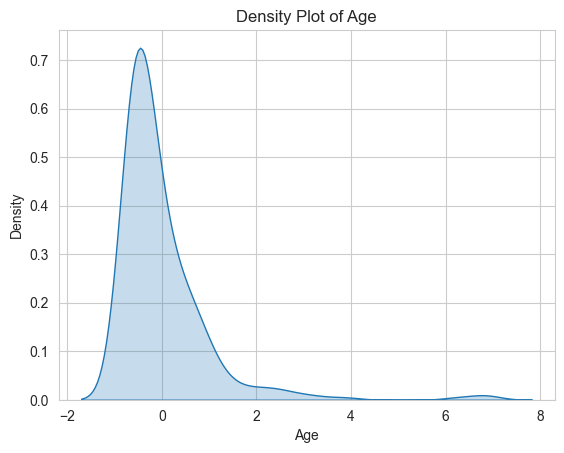

In [152]:
# Assuming "X_train" is your DataFrame and "Age" is the column you want to plot
sns.set_style("whitegrid")  # Optional: Set the plot style
sns.kdeplot(X_train["Age"], shade=True)  # Create a density plot
plt.title("Density Plot of Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

##### Check randomly selected another gene distribution

C:\Users\isile\AppData\Local\Temp\ipykernel_10380\2590785681.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train["Unnamed: 14"], shade=True)  # Create a density plot


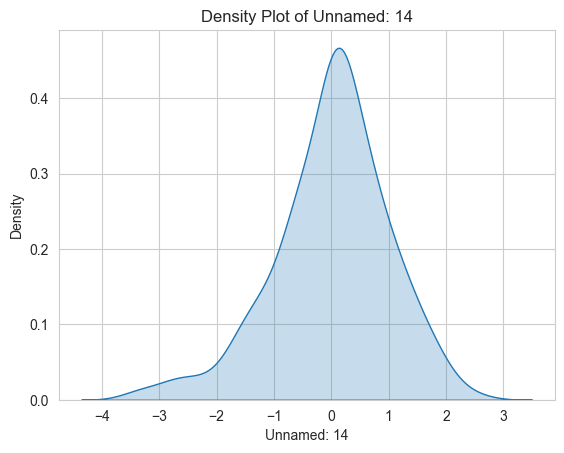

In [153]:
# Assuming "X_train" is your DataFrame and "Age" is the column you want to plot
sns.set_style("whitegrid")  # Optional: Set the plot style
sns.kdeplot(X_train["Unnamed: 14"], shade=True)  # Create a density plot
plt.title("Density Plot of Unnamed: 14")
plt.xlabel("Unnamed: 14")
plt.ylabel("Density")
plt.show()

In [154]:
X_train

,Gender_F,Gender_M,clinico.genetic.subgroup_MNA,clinico.genetic.subgroup_ST1,clinico.genetic.subgroup_ST4,clinico.genetic.subgroup_ST4S,MYCN.status_1,MYCN.status_Amp,Age,Unnamed: 14,...,Unnamed: 44712,Unnamed: 44713,PDE3B,Unnamed: 44715,LINC01588,Unnamed: 44717,Unnamed: 44718,Unnamed: 44719,Unnamed: 44720,Unnamed: 44721
ID,,,,,,,,,,,,,,,,,,,,,
ICGC_466,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.480811,-0.488997,...,-1.653599,-0.106549,0.851564,-1.848442,0.378614,-1.019042,0.089275,-0.019078,0.488320,0.427556
ICGC_292,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.677666,1.277924,...,-1.338185,0.067910,1.017450,-0.278487,-1.188787,-0.878331,0.330762,-0.378721,-0.571040,-0.804698
ICGC_032,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.404137,-0.162796,...,0.974848,0.067910,1.143839,0.615659,0.854896,0.983374,0.049027,0.900780,0.712416,0.174353
ICGC_408,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.026905,0.471483,...,-0.873826,-0.869807,-0.736202,-0.132929,-0.920337,-1.419525,0.089275,-2.349844,-1.915612,0.039312
ICGC_108,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.427002,-0.072185,...,0.002323,0.820265,-0.728302,0.012630,2.552192,0.777720,-0.796179,1.633899,-0.204338,0.663879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICGC_309,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.738639,0.081854,...,-0.023962,0.493154,-0.270141,0.054218,-0.643228,-0.715973,-0.916923,-1.167170,-0.530295,0.039312
ICGC_371,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.518919,1.142007,...,-0.716120,-0.259200,0.180121,0.345336,-0.400757,-0.531968,0.230142,-0.357972,-0.082105,0.393796
ICGC_107,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.379579,0.081854,...,2.043750,0.067910,0.630382,0.470100,0.664383,1.416328,1.095472,1.087518,0.916139,0.292515


#### Feature filtration trial

In [155]:
X_micro = X_train.iloc[:, 9:]

print("Microarray data shape before variance threshold" )
print(X_micro.shape)

## VarianceThreshold

from sklearn.feature_selection import VarianceThreshold
def variance_threshold(df_norm, thr):
    var_thresholder = VarianceThreshold(threshold = thr)
    var_thresholder.fit(df_norm)
    new_columns = var_thresholder.get_support()
    return df_norm.iloc[:, new_columns]



X_micro_vt = variance_threshold(X_micro, thr = 0.05) 
print("Microarray data shape after variance threshold" )
print(X_micro_vt.shape)




Microarray data shape before variance threshold
(298, 43291)
Microarray data shape after variance threshold
(298, 43291)


##### Unsupervised learning for X_train

In [164]:
#En son veriler
X_train=pd.read_csv("X_train.csv", index_col="ID")
X_test=pd.read_csv("X_test.csv", index_col="ID")
y_train=pd.read_csv("y_train.csv", index_col="ID")
y_test=pd.read_csv("y_test.csv", index_col="ID")

In [165]:
#Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [157]:
y_train

,INSS.Stage,HighRisk,Progression,DeathFromDisease
ID,,,,
ICGC_466,4,HR,1,0
ICGC_292,4S,LR,0,0
ICGC_032,1,LR,0,0
ICGC_408,4,HR,1,1
ICGC_108,4,LR,0,0
...,...,...,...,...
ICGC_309,4S,LR,1,0
ICGC_371,4,HR,1,1
ICGC_107,1,LR,0,0


##### y INSS.Stage encoding

In [166]:
from sklearn.preprocessing import LabelEncoder
# #only get one target
y_inss=y_train["INSS.Stage"]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the class labels to numeric values
y_inss_encode = label_encoder.fit_transform(y_inss)

# Now, if you want to get the original labels from the encoded values:
original_labels = label_encoder.inverse_transform(y_inss_encode)

            PC1        PC2         PC3        PC4        PC5        PC6  \
0    136.429334  26.839053  100.917258  26.601161 -35.832602  93.692358   
1     77.007389 -38.366313   29.329642   0.580217 -32.528316 -58.249673   
2   -154.031205 -79.662005  -20.188571  31.973740  17.555876  13.009584   
3    163.177544  65.032714   -3.608451  -9.825297 -58.917323   6.302381   
4   -133.786570 -45.802081  -33.055888 -19.637358  29.963767  15.845037   
..          ...        ...         ...        ...        ...        ...   
293   66.045382 -36.399470   24.146106 -41.046310  -6.998421 -40.226997   
294   -4.147239  45.736297   10.305969  44.871947   5.067008  11.367945   
295 -185.378425 -11.042968   -4.409655 -10.307432  16.971800  13.980904   
296    9.679682 -11.341798   32.091484 -41.033486  -7.401649 -33.868214   
297   44.948340 -22.316972    3.529373 -78.463549   9.966207 -34.370997   

           PC7        PC8        PC9       PC10  
0     0.058986 -12.524957  -2.846144  -4.539018  

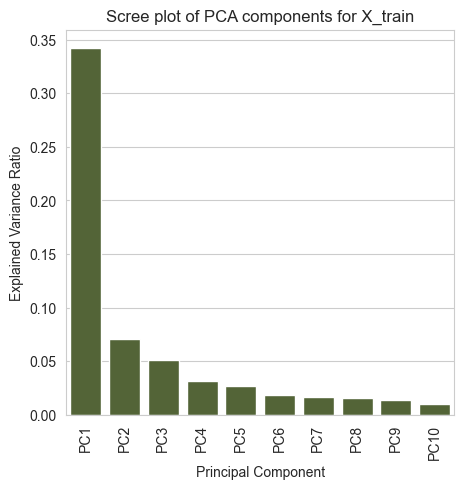

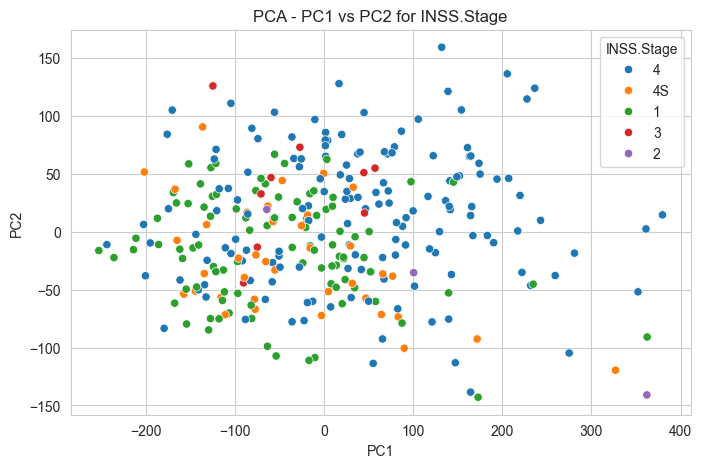

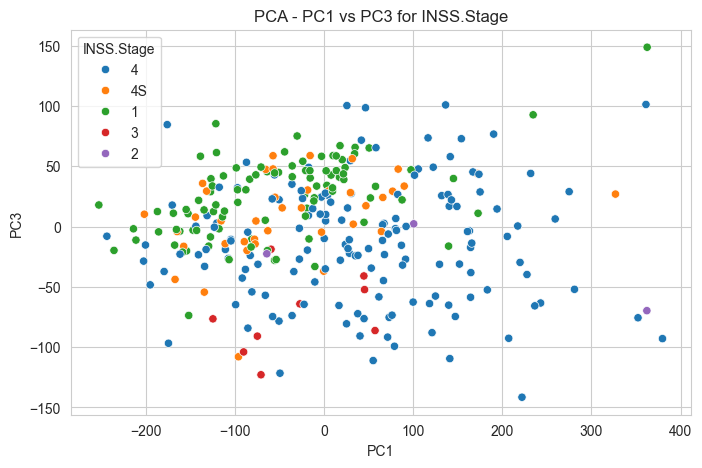

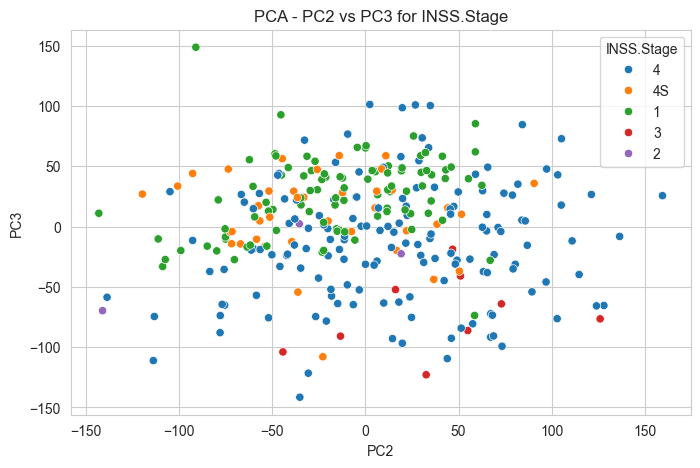

INSS.Stage
4     151
1      96
4S     39
3       9
2       3
Name: count, dtype: int64


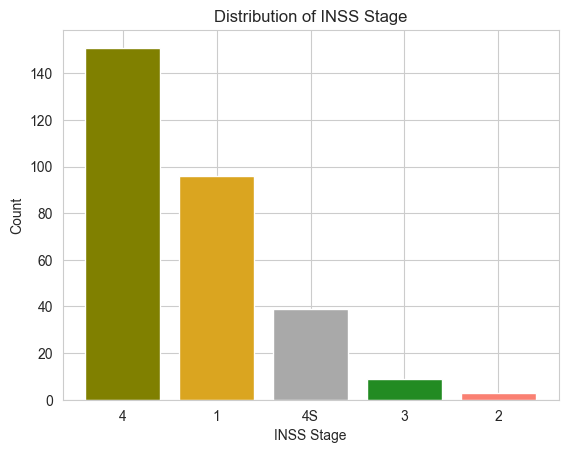

In [172]:
#Perform PCA
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(X_train)

# Convert principal components into a pandas DataFrame
df_pca = pd.DataFrame(data=df_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
print(df_pca)
####################################
#Scree plot
# Explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for easier plotting
df_explained_variance = pd.DataFrame({'PC': [f'PC{i}' for i in range(1, len(explained_variance_ratio) + 1)], 
                                      'Explained Variance Ratio': explained_variance_ratio})

# Plot
plt.figure(figsize=(5, 5))
sns.barplot(x='PC', y='Explained Variance Ratio', data=df_explained_variance, color= "darkolivegreen")
plt.title('Scree plot of PCA components for X_train')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(rotation=90)
plt.show()

########################################

# Visualize different combinations of principal components
df_pca['INSS.Stage'] = y_train["INSS.Stage"].values
combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]
for combo in combinations:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_pca, x=combo[0], y=combo[1], hue='INSS.Stage')
    plt.title(f'PCA - {combo[0]} vs {combo[1]} for INSS.Stage')
    plt.show()
#############################################

#check the representative subgroups for the INSS. Stage in X_train

# Get the distribution of INSS stages
inss_stage_distribution = y_train['INSS.Stage'].value_counts()
print(inss_stage_distribution)
# Define colors for each INSS stage
colors = ['olive', 'goldenrod', 'darkgrey', 'forestgreen', 'salmon', 'darkcyan']

# Create the bar plot with colored bars
plt.bar(inss_stage_distribution.index, inss_stage_distribution.values, color=colors)

# Set labels and title
plt.xlabel('INSS Stage')
plt.ylabel('Count')
plt.title('Distribution of INSS Stage')

# Show the plot
plt.show()

c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\isile\AppData\Local\Temp\ipykernel_10380\2176967141.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_
c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, 

KMeans_Label_k2_INSS   0   1   2
INSS.Stage                      
1                     17  61  18
2                      0   1   2
3                      1   4   4
4                     48  68  35
4S                     6  23  10
INSS.Stage
4     151
1      96
4S     39
3       9
2       3
Name: count, dtype: int64


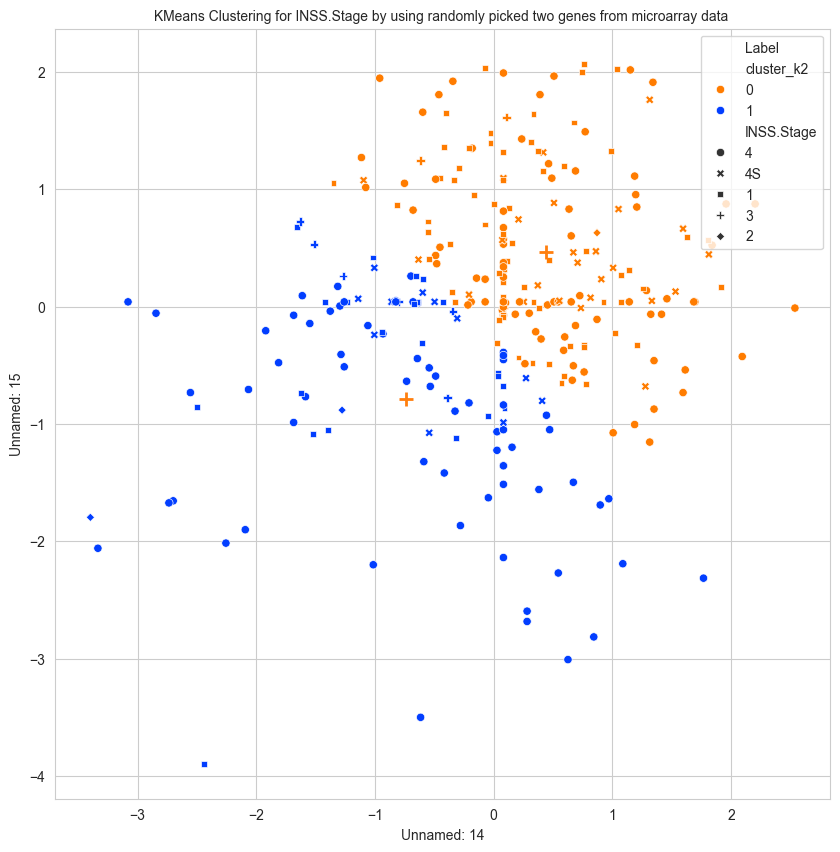

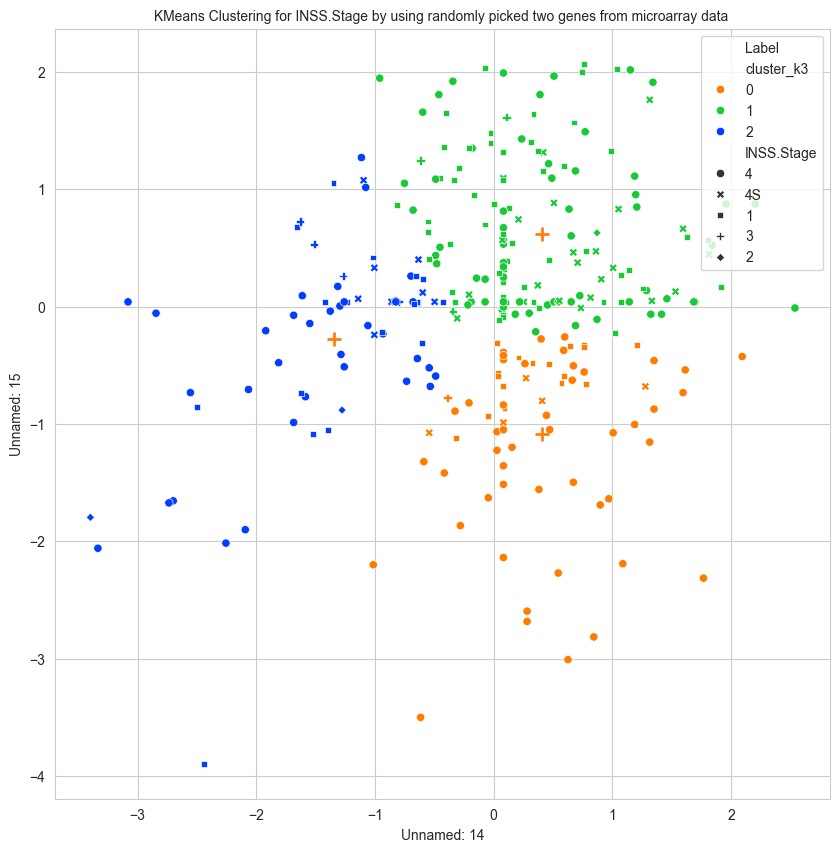

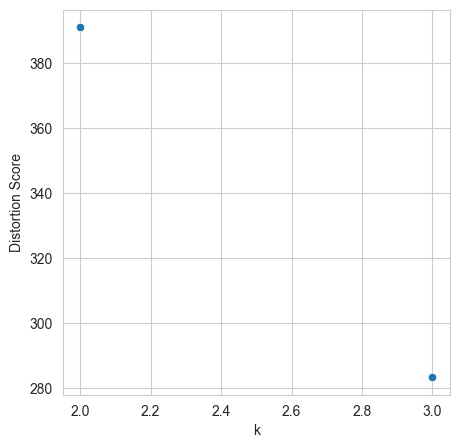

In [174]:
y=y_train.copy()
from sklearn.cluster import KMeans
from sklearn import metrics

X_kmeans = X_train.iloc[:, 9:11] #two genes in microaarray data
k_labels =[]
kmeans_distortion_score = {}


#loop for k=2 and k=3 and plot of them
for k in range(2, 4):
    kmeans = KMeans(n_clusters=k, init='random').fit(X_kmeans.iloc[:,:2])
    kmeans_centroids_plt = pd.DataFrame(kmeans.cluster_centers_, columns=X_kmeans.columns.values.tolist()[:2])
    labels = kmeans.labels_  # Assign cluster labels to 'labels'
    X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_
    k_labels.append(kmeans.labels_)
    kmeans_distortion_score[k] = kmeans.inertia_
    colorPalette = 'bright'
    colors = dict(zip(X_kmeans['cluster_k{}'.format(k)].unique(), sns.color_palette(colorPalette)))
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(x=X_kmeans.iloc[:, 0], y=X_kmeans.iloc[:, 1], hue='cluster_k{}'.format(k), palette=colors, data=X_kmeans, style=y_inss, edgecolor='white')
    ax = sns.scatterplot(x=kmeans_centroids_plt.iloc[:, 0], y=kmeans_centroids_plt.iloc[:, 1], data=kmeans_centroids_plt, linewidth=2.0, marker='+', s=100)
    plt.title("KMeans Clustering for INSS.Stage by using randomly picked two genes from microarray data ", fontsize=10)
    plt.legend(title='Label', loc='upper right', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

#distortion score plot
df_scores = pd.DataFrame()
df_scores['Distortion Score'] = pd.Series(kmeans_distortion_score)
df_scores.index.name = 'k'

fig = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=df_scores.index, y='Distortion Score', data=df_scores)
df_scores

#cross tabular to check how many correct predictions kmeans did
y["KMeans_Label_k2_INSS"] = labels

print (pd.DataFrame(pd.crosstab( y["INSS.Stage"], y["KMeans_Label_k2_INSS"] )))
print(y["INSS.Stage"].value_counts())



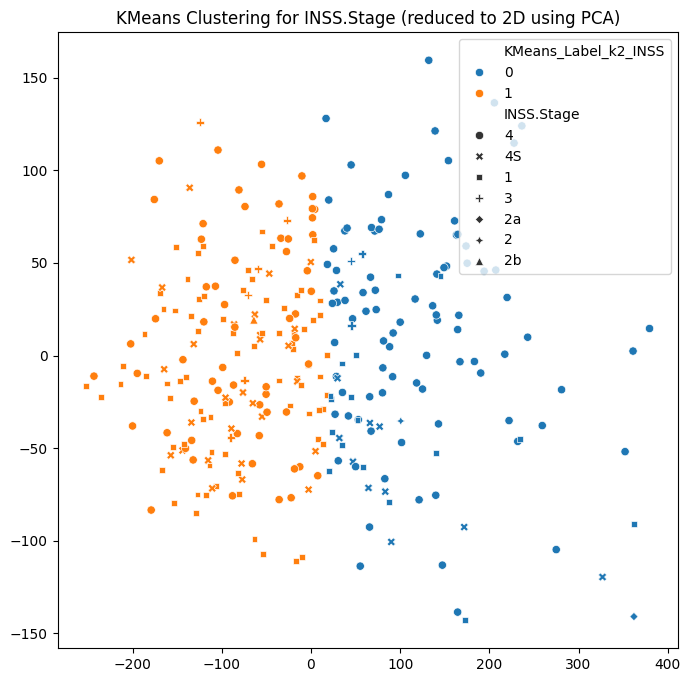

In [ ]:
## #combine PCA and Kmeans for INSS
## Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

#Plot the data
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y["KMeans_Label_k2_INSS"], style = y["INSS.Stage"])
plt.title('KMeans Clustering for INSS.Stage (reduced to 2D using PCA)')
plt.show()



##### y HighRisk encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
# #only get one target
y_hr=y_train["HighRisk"]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the class labels to numeric values
y_hr_encode = label_encoder.fit_transform(y_hr)

# Now, if you want to get the original labels from the encoded values:
original_labels = label_encoder.inverse_transform(y_hr_encode)

            PC1        PC2         PC3        PC4        PC5        PC6  \
0    136.429334  26.839053  100.917257  26.601120 -35.832832  93.695646   
1     77.007389 -38.366313   29.329641   0.580179 -32.528466 -58.240458   
2   -154.031205 -79.662005  -20.188571  31.973778  17.555852  13.007003   
3    163.177544  65.032714   -3.608451  -9.825258 -58.917426   6.298545   
4   -133.786570 -45.802081  -33.055888 -19.637395  29.963724  15.843374   
..          ...        ...         ...        ...        ...        ...   
293   66.045382 -36.399470   24.146107 -41.046356  -6.998421 -40.224097   
294   -4.147239  45.736297   10.305970  44.871928   5.067102  11.370739   
295 -185.378425 -11.042969   -4.409656 -10.307381  16.971638  13.981771   
296    9.679682 -11.341798   32.091483 -41.033508  -7.401776 -33.866966   
297   44.948340 -22.316972    3.529372 -78.463587   9.966177 -34.367247   

           PC7        PC8        PC9       PC10  
0     0.056644 -12.506854  -2.845125  -4.836011  

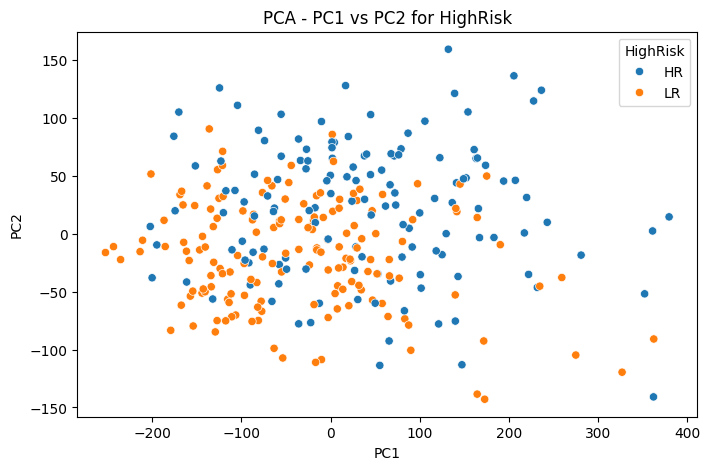

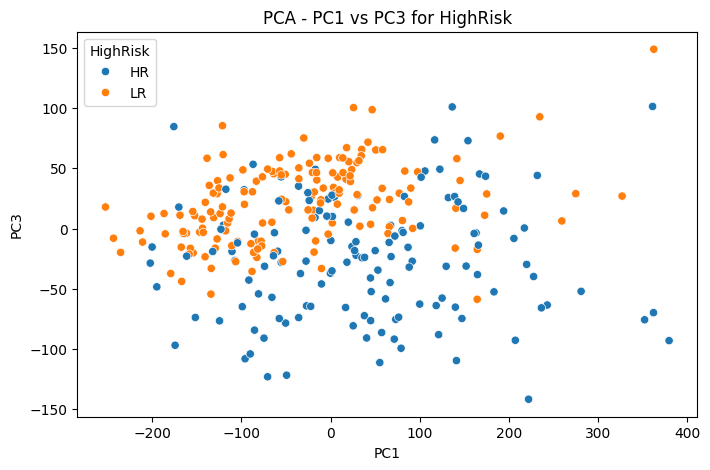

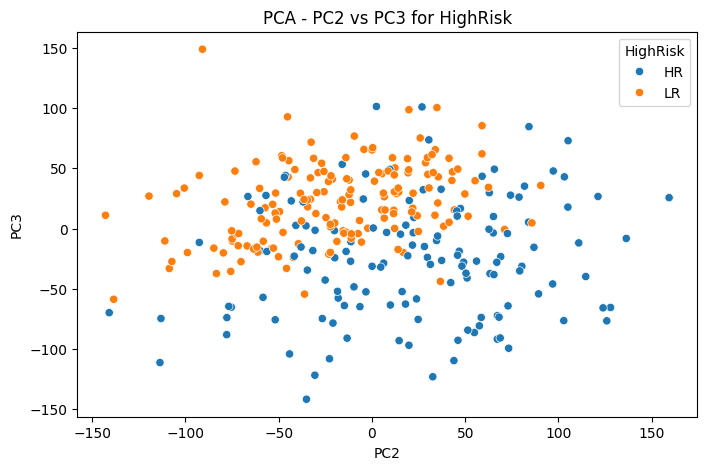

HighRisk
LR    161
HR    137
Name: count, dtype: int64


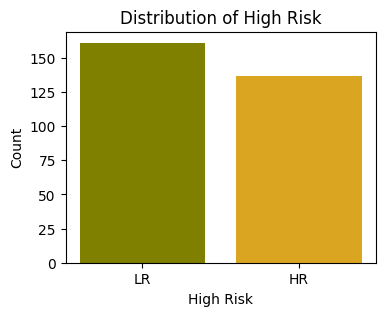

In [ ]:
#Perform PCA
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(X_train)

# Convert principal components into a pandas DataFrame
df_pca = pd.DataFrame(data=df_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
print(df_pca)
####################################
# #Scree plot (same for the above)
# # Explained variance ratio of each principal component
# explained_variance_ratio = pca.explained_variance_ratio_

# # Create a DataFrame for easier plotting
# df_explained_variance = pd.DataFrame({'PC': [f'PC{i}' for i in range(1, len(explained_variance_ratio) + 1)], 
#                                       'Explained Variance Ratio': explained_variance_ratio})

# # Plot
# plt.figure(figsize=(5, 5))
# sns.barplot(x='PC', y='Explained Variance Ratio', data=df_explained_variance, color= "darkolivegreen")
# plt.title('Scree plot of PCA components for X_train')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(rotation=90)
# plt.show()

########################################

# Visualize different combinations of principal components
df_pca['HighRisk'] = y_train["HighRisk"].values
combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]
for combo in combinations:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_pca, x=combo[0], y=combo[1], hue='HighRisk')
    plt.title(f'PCA - {combo[0]} vs {combo[1]} for HighRisk')
    plt.show()
#############################################

#check the representative subgroups for the HighRisk in X_train

# Get the distribution of HighRisk
high_risk_distribution = y_train['HighRisk'].value_counts()
print(high_risk_distribution)
# Define colors for each HighRisk
colors = ['olive', 'goldenrod']

# Create the bar plot with colored bars
plt.figure(figsize=(4, 3))
plt.bar(high_risk_distribution.index, high_risk_distribution.values, color=colors)

# Set labels and title
plt.xlabel('High Risk')
plt.ylabel('Count')
plt.title('Distribution of High Risk')

# Show the plot
plt.show()

In [175]:
y=y_train.copy()
from sklearn.cluster import KMeans
from sklearn import metrics

X_kmeans = X_train.iloc[:, 9:11] #two genes in microaarray data
k_labels =[]
kmeans_distortion_score = {}


#loop for k=2 and k=3 and plot of them
for k in range(2, 4):
    kmeans = KMeans(n_clusters=k, init='random').fit(X_kmeans.iloc[:,:2])
    kmeans_centroids_plt = pd.DataFrame(kmeans.cluster_centers_, columns=X_kmeans.columns.values.tolist()[:2])
    labels = kmeans.labels_  # Assign cluster labels to 'labels'
    X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_
    k_labels.append(kmeans.labels_)
    kmeans_distortion_score[k] = kmeans.inertia_
    colorPalette = 'bright'
    colors = dict(zip(X_kmeans['cluster_k{}'.format(k)].unique(), sns.color_palette(colorPalette)))
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(x=X_kmeans.iloc[:, 0], y=X_kmeans.iloc[:, 1], hue='cluster_k{}'.format(k), palette=colors, data=X_kmeans, style=y_hr, edgecolor='white')
    ax = sns.scatterplot(x=kmeans_centroids_plt.iloc[:, 0], y=kmeans_centroids_plt.iloc[:, 1], data=kmeans_centroids_plt, linewidth=2.0, marker='+', s=100)
    plt.title("KMeans Clustering for HighRisk by using randomly picked two genes from microarray data ", fontsize=10)
    plt.legend(title='Label', loc='upper right', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

#distortion score plot
df_scores = pd.DataFrame()
df_scores['Distortion Score'] = pd.Series(kmeans_distortion_score)
df_scores.index.name = 'k'

fig = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=df_scores.index, y='Distortion Score', data=df_scores)
df_scores

#cross tabular to check how many correct predictions kmeans did
y["KMeans_Label_k2_HR"] = labels

print (pd.DataFrame(pd.crosstab( y["HighRisk"], y["KMeans_Label_k2_HR"] )))
print(y["HighRisk"].value_counts())


c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\isile\AppData\Local\Temp\ipykernel_10380\4218702163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_


NameError: name 'y_hr' is not defined

<Figure size 1000x1000 with 0 Axes>

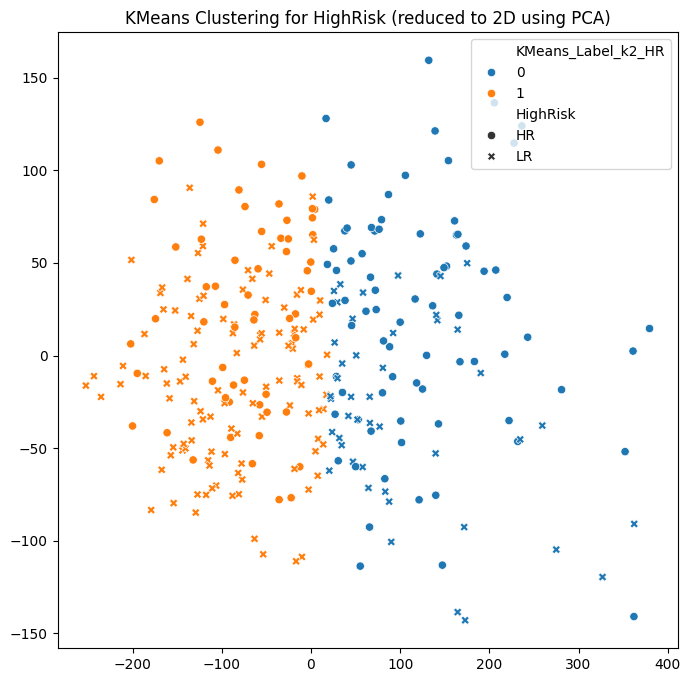

In [ ]:
#### #combine PCA and Kmeans for HighRisk
#  Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

#Plot the data
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y["KMeans_Label_k2_HR"], style = y["HighRisk"])
plt.title('KMeans Clustering for HighRisk (reduced to 2D using PCA)')
plt.show()

##### y Progression encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
# #only get one target
y_progression=y_train["Progression"]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the class labels to numeric values
y_progression_encode = label_encoder.fit_transform(y_progression)

# Now, if you want to get the original labels from the encoded values:
original_labels = label_encoder.inverse_transform(y_progression_encode)

            PC1        PC2         PC3        PC4        PC5        PC6  \
0    136.429334  26.839053  100.917258  26.601239 -35.832531  93.693319   
1     77.007389 -38.366313   29.329641   0.580279 -32.528241 -58.247774   
2   -154.031205 -79.662005  -20.188571  31.973765  17.555838  13.009481   
3    163.177544  65.032714   -3.608452  -9.825310 -58.917481   6.300629   
4   -133.786570 -45.802081  -33.055888 -19.637384  29.963742  15.844546   
..          ...        ...         ...        ...        ...        ...   
293   66.045382 -36.399470   24.146107 -41.046352  -6.998406 -40.225642   
294   -4.147239  45.736297   10.305970  44.871947   5.067090  11.368691   
295 -185.378425 -11.042969   -4.409656 -10.307355  16.971713  13.981137   
296    9.679682 -11.341799   32.091483 -41.033475  -7.401632 -33.868969   
297   44.948340 -22.316972    3.529373 -78.463567   9.966246 -34.370197   

           PC7        PC8        PC9       PC10  
0     0.063914 -12.526749  -2.813102  -4.559612  

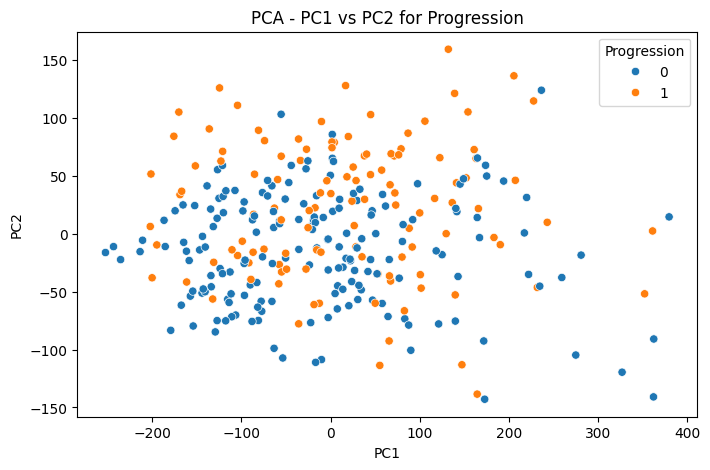

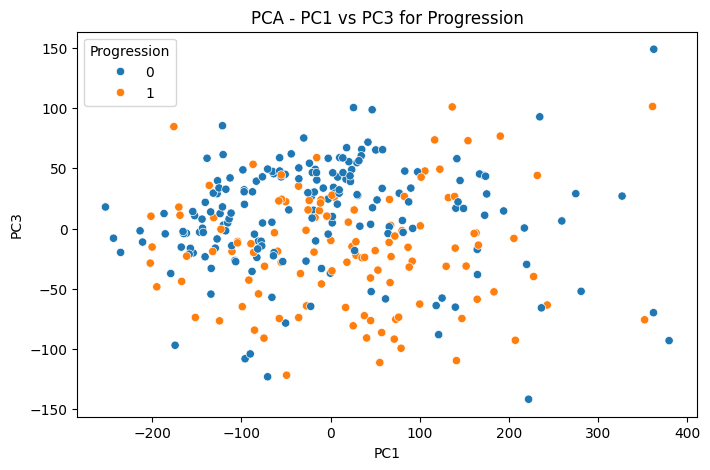

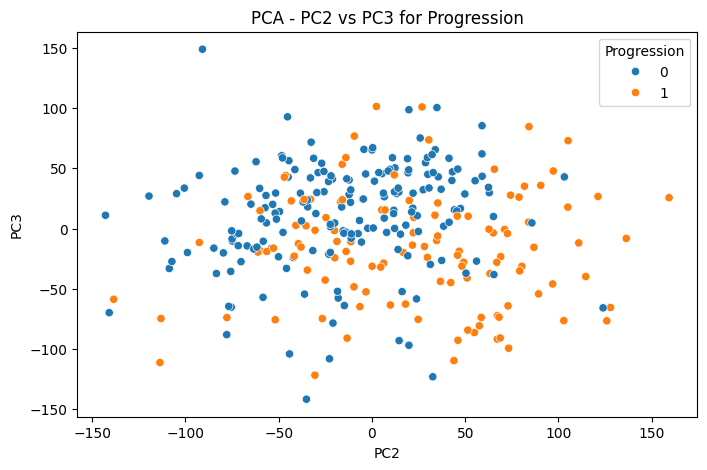

Progression
0    181
1    117
Name: count, dtype: int64


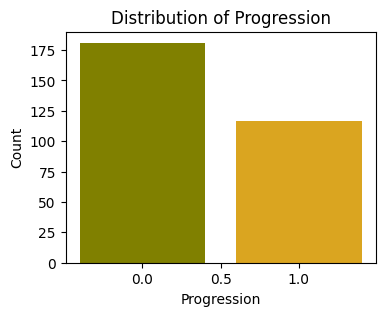

In [ ]:
#Perform PCA
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(X_train)

# Convert principal components into a pandas DataFrame
df_pca = pd.DataFrame(data=df_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
print(df_pca)
####################################
# #Scree plot (same for the above)
# # Explained variance ratio of each principal component
# explained_variance_ratio = pca.explained_variance_ratio_

# # Create a DataFrame for easier plotting
# df_explained_variance = pd.DataFrame({'PC': [f'PC{i}' for i in range(1, len(explained_variance_ratio) + 1)], 
#                                       'Explained Variance Ratio': explained_variance_ratio})

# # Plot
# plt.figure(figsize=(5, 5))
# sns.barplot(x='PC', y='Explained Variance Ratio', data=df_explained_variance, color= "darkolivegreen")
# plt.title('Scree plot of PCA components for X_train')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(rotation=90)
# plt.show()

########################################

# Visualize different combinations of principal components
df_pca['Progression'] = y_train["Progression"].values
combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]
for combo in combinations:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_pca, x=combo[0], y=combo[1], hue='Progression')
    plt.title(f'PCA - {combo[0]} vs {combo[1]} for Progression')
    plt.show()
#############################################

#check the representative subgroups for the Progression in X_train

# Get the distribution of Progression 
progression_distribution = y_train['Progression'].value_counts()
print(progression_distribution)
# Define colors for each Progression 
colors = ['olive', 'goldenrod']

# Create the bar plot with colored bars
plt.figure(figsize=(4, 3))
plt.bar(progression_distribution.index, progression_distribution.values, color=colors)

# Set labels and title
plt.xlabel('Progression')
plt.ylabel('Count')
plt.title('Distribution of Progression')

# Show the plot
plt.show()

In [162]:
y=y_train.copy()
from sklearn.cluster import KMeans
from sklearn import metrics

X_kmeans = X_train.iloc[:, 9:11] #two genes in microaarray data
k_labels =[]
kmeans_distortion_score = {}


#loop for k=2 and k=3 and plot of them
for k in range(2, 4):
    kmeans = KMeans(n_clusters=k, init='random').fit(X_kmeans.iloc[:,:2])
    kmeans_centroids_plt = pd.DataFrame(kmeans.cluster_centers_, columns=X_kmeans.columns.values.tolist()[:2])
    labels = kmeans.labels_  # Assign cluster labels to 'labels'
    X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_
    k_labels.append(kmeans.labels_)
    kmeans_distortion_score[k] = kmeans.inertia_
    colorPalette = 'bright'
    colors = dict(zip(X_kmeans['cluster_k{}'.format(k)].unique(), sns.color_palette(colorPalette)))
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(x=X_kmeans.iloc[:, 0], y=X_kmeans.iloc[:, 1], hue='cluster_k{}'.format(k), palette=colors, data=X_kmeans, style=y_progression, edgecolor='white')
    ax = sns.scatterplot(x=kmeans_centroids_plt.iloc[:, 0], y=kmeans_centroids_plt.iloc[:, 1], data=kmeans_centroids_plt, linewidth=2.0, marker='+', s=100)
    plt.title("KMeans Clustering for Progression by using randomly picked two genes from microarray data ", fontsize=10)
    plt.legend(title='Label', loc='upper right', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

#distortion score plot
df_scores = pd.DataFrame()
df_scores['Distortion Score'] = pd.Series(kmeans_distortion_score)
df_scores.index.name = 'k'

fig = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=df_scores.index, y='Distortion Score', data=df_scores)
df_scores

#cross tabular to check how many correct predictions kmeans did
y["KMeans_Label_k2_progression"] = labels

print (pd.DataFrame(pd.crosstab( y["Progression"], y["KMeans_Label_k2_progression"] )))
print(y["Progression"].value_counts())


c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\isile\AppData\Local\Temp\ipykernel_10380\173434870.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_


NameError: name 'y_progression' is not defined

<Figure size 1000x1000 with 0 Axes>

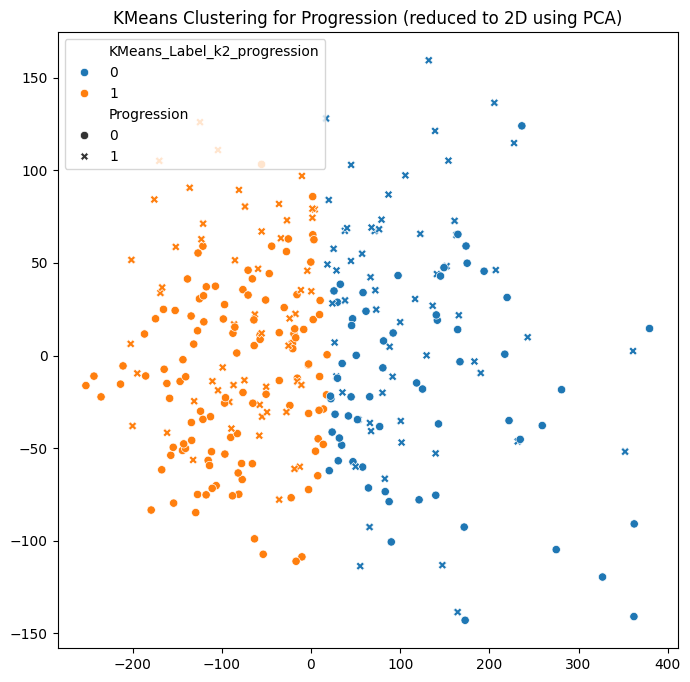

In [156]:
#### #combine PCA and Kmeans for HighRisk
#  Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

#Plot the data
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y["KMeans_Label_k2_progression"], style = y["Progression"])
plt.title('KMeans Clustering for Progression (reduced to 2D using PCA)')
plt.show()


##### y DeathFromDisease encoding

In [41]:
from sklearn.preprocessing import LabelEncoder
# #only get one target
y_death=y_train["DeathFromDisease"]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the class labels to numeric values
y_death_encode = label_encoder.fit_transform(y_death)

# Now, if you want to get the original labels from the encoded values:
original_labels = label_encoder.inverse_transform(y_death_encode)

            PC1        PC2         PC3        PC4        PC5        PC6  \
0    136.429334  26.839053  100.917256  26.601278 -35.832735  93.693909   
1     77.007389 -38.366313   29.329642   0.580184 -32.528208 -58.250502   
2   -154.031205 -79.662005  -20.188571  31.973749  17.555841  13.009607   
3    163.177544  65.032714   -3.608452  -9.825263 -58.917492   6.300311   
4   -133.786570 -45.802081  -33.055889 -19.637338  29.963699  15.844940   
..          ...        ...         ...        ...        ...        ...   
293   66.045382 -36.399470   24.146107 -41.046336  -6.998422 -40.226184   
294   -4.147239  45.736297   10.305971  44.871902   5.067144  11.368495   
295 -185.378425 -11.042969   -4.409656 -10.307365  16.971698  13.980576   
296    9.679682 -11.341798   32.091482 -41.033412  -7.401754 -33.866993   
297   44.948340 -22.316972    3.529373 -78.463552   9.966247 -34.370204   

           PC7        PC8        PC9       PC10  
0     0.049370 -12.522448  -2.818402  -4.553719  

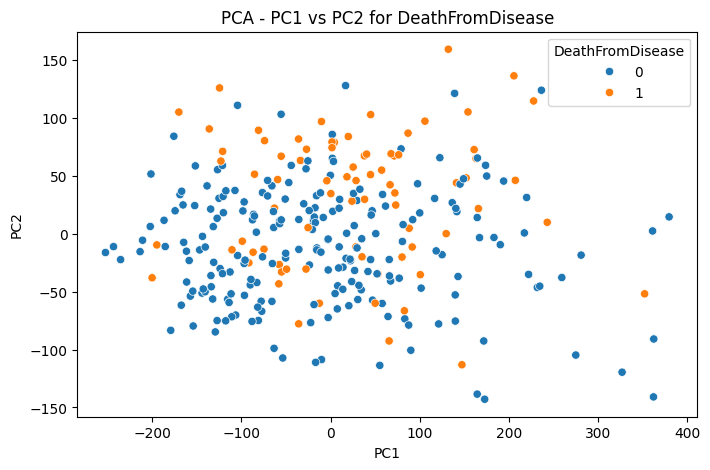

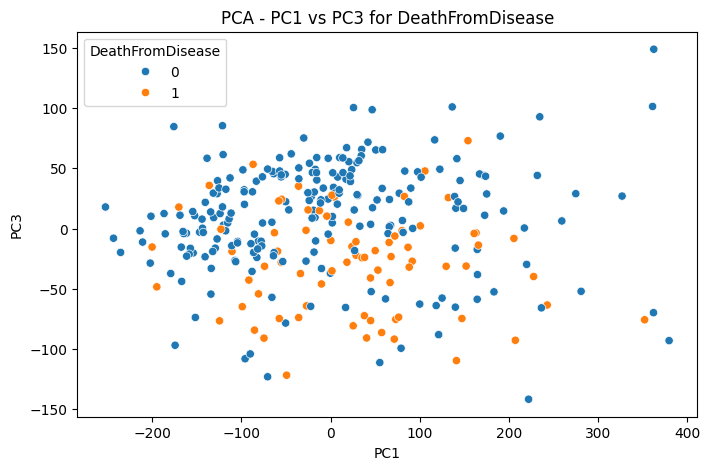

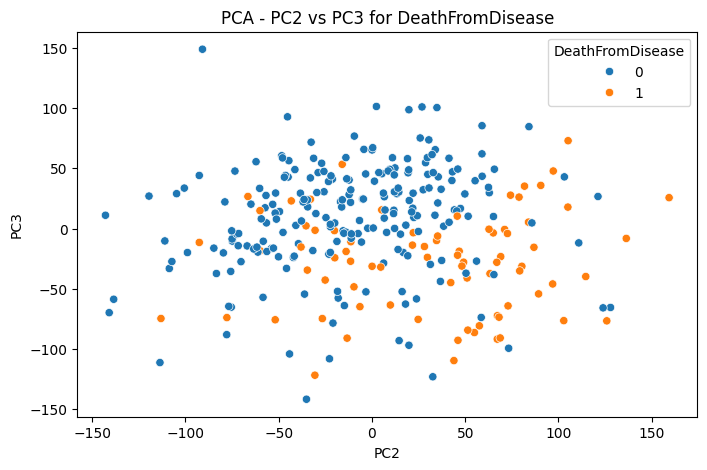

DeathFromDisease
0    220
1     78
Name: count, dtype: int64


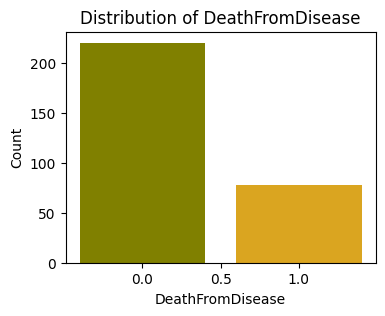

In [43]:
#Perform PCA
from sklearn.decomposition import PCA

n_components = 10

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(X_train)

# Convert principal components into a pandas DataFrame
df_pca = pd.DataFrame(data=df_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
print(df_pca)
####################################
# #Scree plot (same for the above)
# # Explained variance ratio of each principal component
# explained_variance_ratio = pca.explained_variance_ratio_

# # Create a DataFrame for easier plotting
# df_explained_variance = pd.DataFrame({'PC': [f'PC{i}' for i in range(1, len(explained_variance_ratio) + 1)], 
#                                       'Explained Variance Ratio': explained_variance_ratio})

# # Plot
# plt.figure(figsize=(5, 5))
# sns.barplot(x='PC', y='Explained Variance Ratio', data=df_explained_variance, color= "darkolivegreen")
# plt.title('Scree plot of PCA components for X_train')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(rotation=90)
# plt.show()

########################################

# Visualize different combinations of principal components
df_pca['DeathFromDisease'] = y_train["DeathFromDisease"].values
combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]
for combo in combinations:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_pca, x=combo[0], y=combo[1], hue='DeathFromDisease')
    plt.title(f'PCA - {combo[0]} vs {combo[1]} for DeathFromDisease')
    plt.show()
#############################################

#check the representative subgroups for the DeathFromDisease in X_train

# Get the distribution of DeathFromDisease
death_distribution = y_train['DeathFromDisease'].value_counts()
print(death_distribution)
# Define colors for each DeathFromDisease
colors = ['olive', 'goldenrod']

# Create the bar plot with colored bars
plt.figure(figsize=(4, 3))
plt.bar(death_distribution.index, death_distribution.values, color=colors)

# Set labels and title
plt.xlabel('DeathFromDisease')
plt.ylabel('Count')
plt.title('Distribution of DeathFromDisease')

# Show the plot
plt.show()

##### Kmeans clustering

c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\isile\AppData\Local\Temp\ipykernel_4204\4034377567.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_
c:\Users\isile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, d

KMeans_Label_k2_death   0    1
DeathFromDisease              
0                      80  140
1                      43   35
DeathFromDisease
0    220
1     78
Name: count, dtype: int64


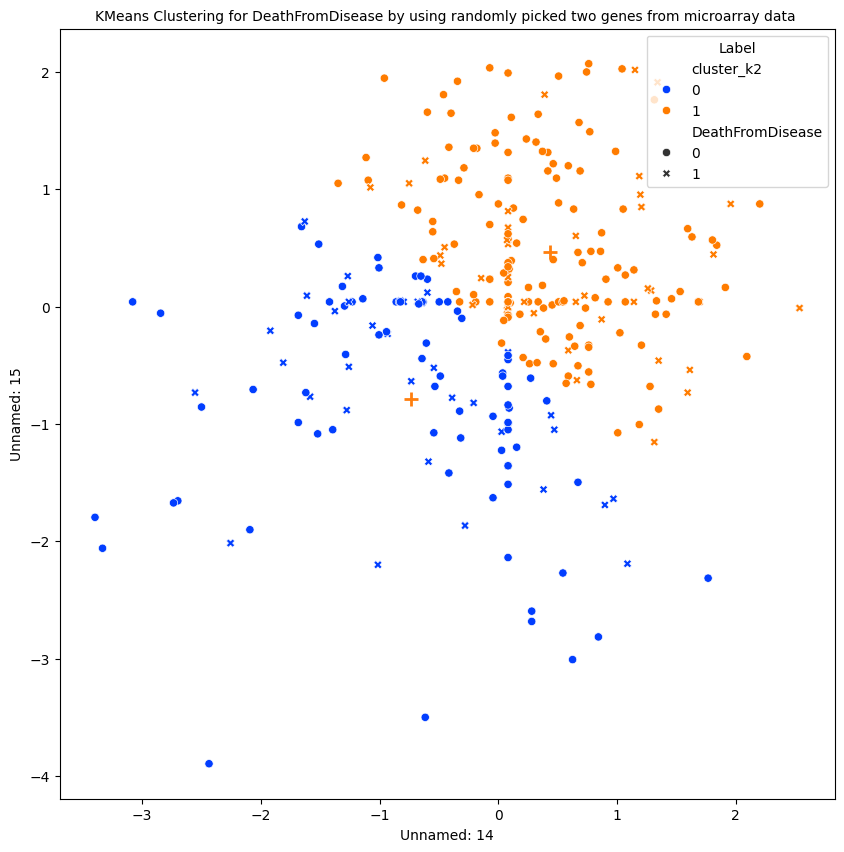

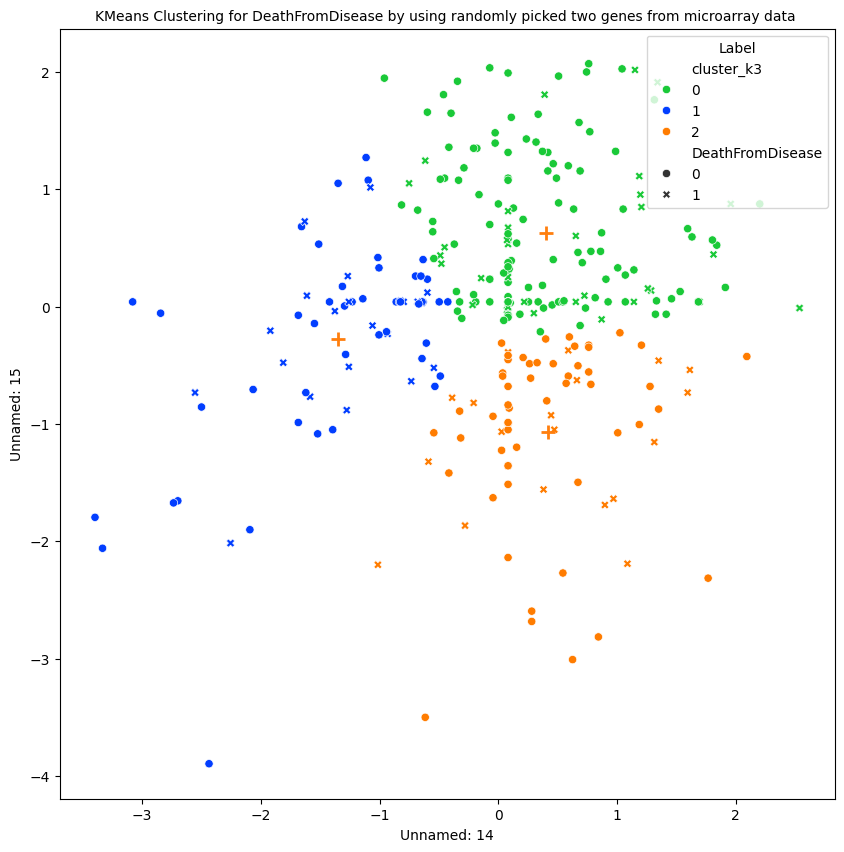

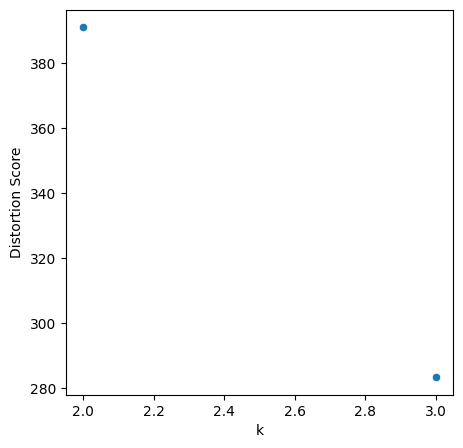

In [150]:
y=y_train.copy()
from sklearn.cluster import KMeans
from sklearn import metrics

X_kmeans = X_train.iloc[:, 9:11] #two genes in microaarray data
k_labels =[]
kmeans_distortion_score = {}


#loop for k=2 and k=3 and plot of them
for k in range(2, 4):
    kmeans = KMeans(n_clusters=k, init='random').fit(X_kmeans.iloc[:,:2])
    kmeans_centroids_plt = pd.DataFrame(kmeans.cluster_centers_, columns=X_kmeans.columns.values.tolist()[:2])
    labels = kmeans.labels_  # Assign cluster labels to 'labels'
    X_kmeans['cluster_k{}'.format(k)] = kmeans.labels_
    k_labels.append(kmeans.labels_)
    kmeans_distortion_score[k] = kmeans.inertia_
    colorPalette = 'bright'
    colors = dict(zip(X_kmeans['cluster_k{}'.format(k)].unique(), sns.color_palette(colorPalette)))
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(x=X_kmeans.iloc[:, 0], y=X_kmeans.iloc[:, 1], hue='cluster_k{}'.format(k), palette=colors, data=X_kmeans, style=y_death, edgecolor='white')
    ax = sns.scatterplot(x=kmeans_centroids_plt.iloc[:, 0], y=kmeans_centroids_plt.iloc[:, 1], data=kmeans_centroids_plt, linewidth=2.0, marker='+', s=100)
    plt.title("KMeans Clustering for DeathFromDisease by using randomly picked two genes from microarray data ", fontsize=10)
    plt.legend(title='Label', loc='upper right', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

#distortion score plot
df_scores = pd.DataFrame()
df_scores['Distortion Score'] = pd.Series(kmeans_distortion_score)
df_scores.index.name = 'k'

fig = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=df_scores.index, y='Distortion Score', data=df_scores)
df_scores

#cross tabular to check how many correct predictions kmeans did
y["KMeans_Label_k2_death"] = labels

print (pd.DataFrame(pd.crosstab( y["DeathFromDisease"], y["KMeans_Label_k2_death"] )))
print(y["DeathFromDisease"].value_counts())





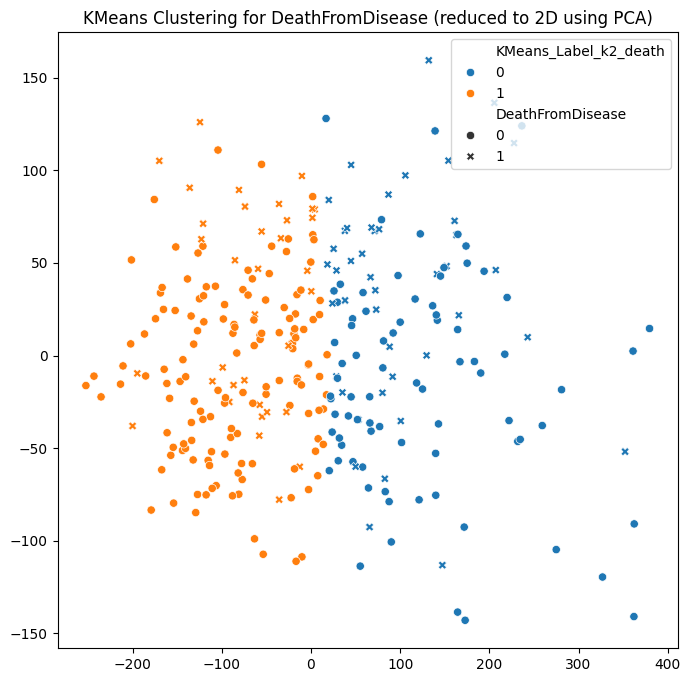

In [151]:
#### #combine PCA and Kmeans for DeathFromDisease
#  Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

#Plot the data
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y["KMeans_Label_k2_death"], style = y["DeathFromDisease"])
plt.title('KMeans Clustering for DeathFromDisease (reduced to 2D using PCA)')
plt.show()



In [80]:
y["DeathFromDisease"].value_counts()

DeathFromDisease
0    220
1     78
Name: count, dtype: int64

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,DeathFromDisease
0,136.429334,26.839053,100.917256,26.601278,-35.832735,93.693909,0.049370,-12.522448,-2.818402,-4.553719,0
1,77.007389,-38.366313,29.329642,0.580184,-32.528208,-58.250502,-0.834509,28.369988,-5.229195,-29.991135,0
2,-154.031205,-79.662005,-20.188571,31.973749,17.555841,13.009607,35.709814,-21.422813,3.647671,1.075650,0
3,163.177544,65.032714,-3.608452,-9.825263,-58.917492,6.300311,-18.889397,-28.073248,62.269603,36.647502,1
4,-133.786570,-45.802081,-33.055889,-19.637338,29.963699,15.844940,46.725551,2.215514,13.521235,-10.164652,0
...,...,...,...,...,...,...,...,...,...,...,...
293,66.045382,-36.399470,24.146107,-41.046336,-6.998422,-40.226184,-13.402170,-10.859890,-2.996946,17.400554,0
294,-4.147239,45.736297,10.305971,44.871902,5.067144,11.368495,-29.921956,13.990686,-21.555236,24.136226,1
295,-185.378425,-11.042969,-4.409656,-10.307365,16.971698,13.980576,1.280589,-4.326142,-1.518241,7.743426,0
296,9.679682,-11.341798,32.091482,-41.033412,-7.401754,-33.866993,26.974935,-28.161540,-15.419414,-16.057885,0


In [ ]:
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_temp_2D = pca.fit_transform(X_train_temp_norm)

#Plot the data

#ax = sns.scatterplot(x=X_train_temp_2D[:, 0], y=X_train_temp_2D[:, 1], data=X_train_temp_2D)
ax = sns.scatterplot(x=df_pca["PC1"], y=df_pca["PC2"], hue=y["KMeans_Label_k2"], style = y["DeathFromDisease"])

plt.title('KMeans Clustering (reduced to 2D using PCA)')
plt.show()


In [ ]:
# #only get one target
y=y_all["INSS.Stage"]

# Assuming 'df' is your DataFrame
# You can count the occurrences of each 'INSS.Stage'
class_counts = y_all['INSS.Stage'].value_counts()

# Identify classes with fewer than 3 occurrences
minority_classes = class_counts[class_counts < 2].index

#Get the index numbers of the samples to be dropped
samples_to_drop = y_all[y_all['INSS.Stage'].isin(minority_classes)].index.tolist()


# Filter the DataFrame to exclude samples with these classes
y_all_filtered = y_all[~y_all['INSS.Stage'].isin(minority_classes)]
y=y_all_filtered["INSS.Stage"]

FEATURE SELECTION

In [ ]:
# # Import necessary libraries
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile
# from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold
# from sklearn.metrics import accuracy_score

# skf = StratifiedKFold(n_splits=5)

# rf = RandomForestClassifier()

# ## Number of top features
# top_k = 300

# # Initialize list to hold common features from each fold
# common_features = []

# # Iterate over each split
# # Iterate over each split
# for train_index, test_index in skf.split(X, y):
#     X_train_temp, X_test_temp = X.iloc[train_index], X.iloc[test_index]  
#     y_train_temp, y_test_temp = y[train_index], y[test_index]

#     # Initialize feature selectors
#     selector_kbest = SelectKBest(score_func=f_classif, k=top_k)  # Adjust 'k' as per your requirements
#     selector_percentile = SelectPercentile(score_func=f_classif, percentile=1)
    
#     # Fit and transforX_train, y_trainm the data
#     X_new_kbest = selector_kbest.fit_transform(X_train_temp, y_train_temp)
#     X_new_percentile = selector_percentile.fit_transform(X_train_temp, y_train_temp)
    
#     # Get the selected features
#     selected_features_kbest = X_train_temp.columns[selector_kbest.get_support()]
#     selected_features_percentile = X_train_temp.columns[selector_percentile.get_support()]
    
#     # Get the common features and add to the list
#     common_features_fold = set(selected_features_kbest) & set(selected_features_percentile)
#     common_features.append(common_features_fold)
#     #print("Common Features in thi Fold : ", common_features_fold )

#     # Train the model on the selected features and compute the accuracy
#     X_train_selected = X_train_temp[list(common_features_fold)]
#     X_test_selected = X_test_temp[list(common_features_fold)]
#     rf.fit(X_train_selected, y_train_temp)
#     y_pred = rf.predict(X_test_selected)
#     accuracy = accuracy_score(y_test_temp, y_pred)
#     print(f'Accuracy for this fold: {accuracy}')


# # Get the intersection of common features from all folds
# final_common_features = set.intersection(*map(set, common_features))

# print(f"Final common features: {final_common_features}")

In [ ]:
# y_all = pd.read_csv("y_train.csv")

# y_all['INSS.Stage'].value_counts()
# y_all.shape

(298, 5)